# Vision Language Model Evaluation

This notebook evaluates multiple vision language models (e.g., LLaVA-NeXT, GPT-5o and Qwen3-VL) on three systematically constructed image datasets designed to probe color-concept representations: canonical object colors, counterfactual recolorings and abstract colored shapes.


In [1]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration,
    AutoProcessor,
    AutoModelForVision2Seq
)
import torch
import pandas as pd
import gc
import numpy as np
from tqdm import tqdm
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import re

ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from test_MLLMs import run_vlm_evaluation, ask_vlm_introspection_threshold
from making_color_images.plot_variants import (plot_vlm_prolific,
                                            plot_fg_response_frequencies_line,
                                            plot_fg_response_frequencies_bar,
                                            plot_bg_response_frequencies_bar,
                                            plot_bg_response_frequencies_line,
                                            plot_model_logprobs,)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

In [3]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda


60

In [4]:
# Load the datasets that where also used in the human evaluation
prior_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_image_priors_prolific.csv")
counterfact_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_counterfact_prolific.csv")
shape_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_shapes_prolific.csv")

def norm_image_paths(df):
    df = df.copy()
    df["image_path"] = df["image_path"].apply(
    lambda p: str(DATA / p)
    )
    return df

prior_df = norm_image_paths(prior_df)
counterfact_df = norm_image_paths(counterfact_df)
shape_df = norm_image_paths(shape_df)

display(prior_df.head(), prior_df.shape, counterfact_df.head(), counterfact_df.shape, shape_df.head(), shape_df.shape)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,correct_prior,brown,brown,FG,100,FG 100% (seq),seq


(1260, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,counterfact,red,red,FG,20,FG 20% (seq),seq


(412, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,orange,orange,FG,90,FG 90% (seq),seq


(1331, 9)

In [5]:
def evaluate_vlm_on_stimuli(
    df_stimuli: pd.DataFrame,
    *,
    processor=None,
    model=None,
    device,
    image_root: Path,
    backend: str = "llava",      # "llava" | "qwen" | "gpt4" | "gpt52"
    model_name: str | None = None,
    batch_size: int = 1,
    mode: str = "this",
    calibration_value: int | None = None,
    desc: str = "Evaluating stimuli",
    multiturn_introspection=False,
):
    """
    Evaluate a VLM on a set of stimulus images.

    Expects df_stimuli to have columns:
      - image_path (relative)
      - object
      - target_color
    """

    outputs = []

    for _, row in tqdm(
        df_stimuli.iterrows(),
        total=len(df_stimuli),
        desc=desc,
    ):

        # Build single-row eval input
        df_eval_input = pd.DataFrame({
            "image_path": [image_root / row["image_path"]],
            "object": [row["object"]],
            "correct_answer": [row["target_color"]],
        })

        # Run backend-specific evaluation
        df_eval = run_vlm_evaluation(
            df=df_eval_input,
            processor=processor,
            model=model,
            device=device,
            backend=backend,
            model_name=model_name,
            mode=mode,
            calibration_value=calibration_value,
            multiturn_introspection=multiturn_introspection,
        )

        if df_eval is None or len(df_eval) == 0:
            raise ValueError("Model returned empty dataframe.")

        # Normalize column names (GPT vs others)
        if "pred_color_this" in df_eval.columns:
            df_eval = df_eval.rename(
                columns={"pred_color_this": "predicted_color"}
            )

        # Required columns check
        required = {"object", "image_path", "correct_answer", "predicted_color"}
        missing = required - set(df_eval.columns)
        if missing:
            raise ValueError(
                f"Missing required columns in model output: {missing}"
            )

        outputs.append(df_eval)

        # GPU memory hygiene
        if backend in ["llava", "qwen"]:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

    if len(outputs) == 0:
        return pd.DataFrame()

    return pd.concat(outputs, ignore_index=True)

In [6]:
VALID_COLORS = {
    "white", "brown", "grey", "green",
    "red", "blue", "orange",
    "yellow", "pink", "purple",
    "black"
}

# Things that should count as white
WHITE_EQUIVALENTS = {
    "uncolored",
    "unknown",
    "transparent",
    "none",
}

def normalize_color_prediction(raw):

    if raw is None:
        return None

    raw = raw.lower().strip()
    raw = re.sub(r"[^\w\s-]", "", raw)
    raw = raw.replace("-", " ")
    tokens = raw.split()

    if not tokens:
        return None

    if any(tok in WHITE_EQUIVALENTS for tok in tokens):
        return "white"

    # special case: black and white
    if "black" in tokens and "white" in tokens:
        return "white"

    # direct single-color match
    if len(tokens) == 1 and tokens[0] in VALID_COLORS:
        return tokens[0]

    # first valid canonical color in phrase
    for tok in tokens:
        if tok in VALID_COLORS:
            return tok

    return "other"

# 1. LLaVA-NeXT

In [7]:
llava_model_name = "llava-v1.6-mistral-7b-hf"
llava_processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
llava_model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

LLAVA = DATA / "LLaVA-NeXT_results"
LLAVA.mkdir(parents=True, exist_ok=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1.1. Introspection question (LLaVA-NeXT)

In [8]:
calibration = ask_vlm_introspection_threshold(
    backend="llava",
    processor=llava_processor,
    model=llava_model,
    device=device,
    model_name=llava_model_name,
)

llava_threshold = calibration["introspection_threshold"]
print(llava_threshold)

[INST]  
For any object, x% of its pixels should be colored for it to be considered that color.
For example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
At what point would you personally say that the banana in the image is yellow?
What value should x% be?
Please only answer with a single number between 0 and 100.
[/INST] 50 
50


## 1.2.1 Color Prior Dataset (LLaVA-NeXT)

In [ ]:
suffix = "image_priors"
llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [17:34<00:00,  1.20it/s]

                                             image_path          object  \
0     /mnt/lustre/work/eickhoff/esx061/color-concept...          cheese   
1     /mnt/lustre/work/eickhoff/esx061/color-concept...  espresso maker   
2     /mnt/lustre/work/eickhoff/esx061/color-concept...       tile roof   
3     /mnt/lustre/work/eickhoff/esx061/color-concept...           cloud   
4     /mnt/lustre/work/eickhoff/esx061/color-concept...  frilled lizard   
...                                                 ...             ...   
1255  /mnt/lustre/work/eickhoff/esx061/color-concept...        eggplant   
1256  /mnt/lustre/work/eickhoff/esx061/color-concept...     rattlesnake   
1257  /mnt/lustre/work/eickhoff/esx061/color-concept...       tow truck   
1258  /mnt/lustre/work/eickhoff/esx061/color-concept...           snake   
1259  /mnt/lustre/work/eickhoff/esx061/color-concept...      rottweiler   

     correct_answer predicted_color logprob_pred_token logprob_correct_token  \
0             white

,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.256501,-10.654939,False,NaN,white,last,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,-1.101001,-12.749438,False,NaN,black,last,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.028346,-11.536159,False,NaN,red,last,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.142373,-14.216591,False,NaN,grey,last,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.161806,-10.232119,False,NaN,brown,last,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.119483,-9.025734,False,NaN,purple,last,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.459060,-12.091872,False,NaN,black,last,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.095186,-10.251436,False,NaN,brown,last,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.058242,-11.409804,False,NaN,green,last,correct_prior,green,green,FG,50,FG 50% (seq),seq


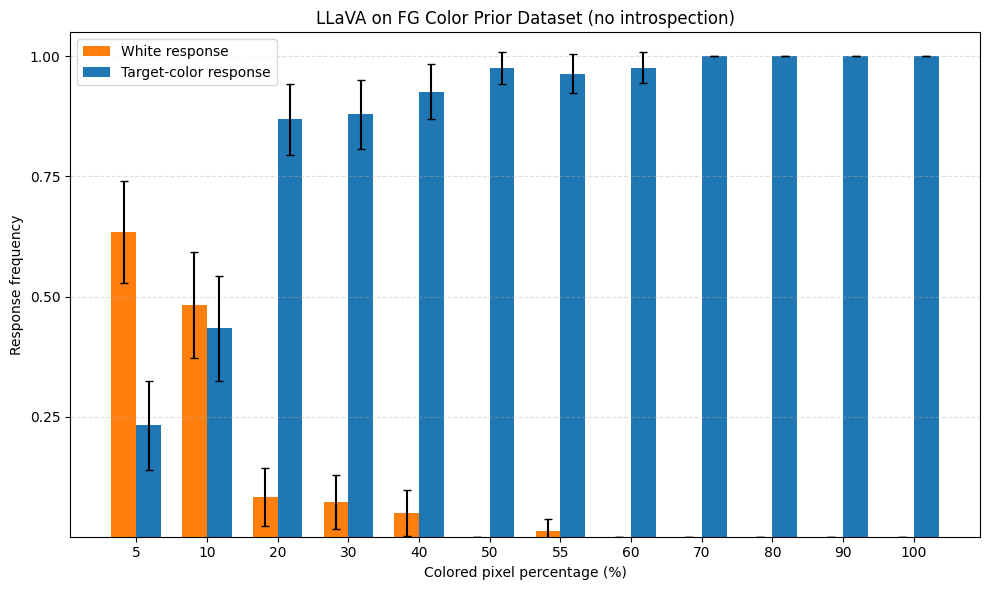

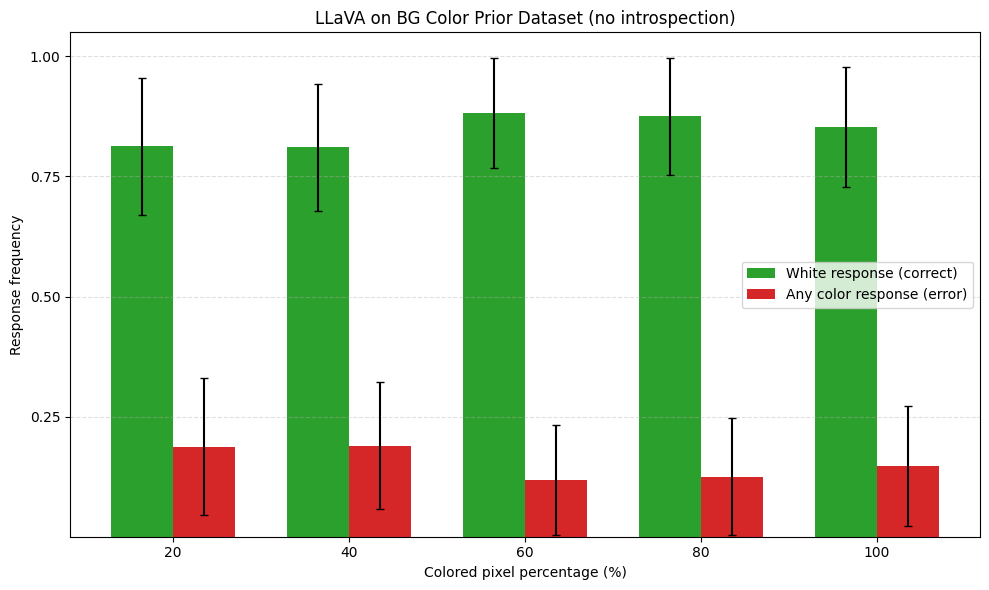

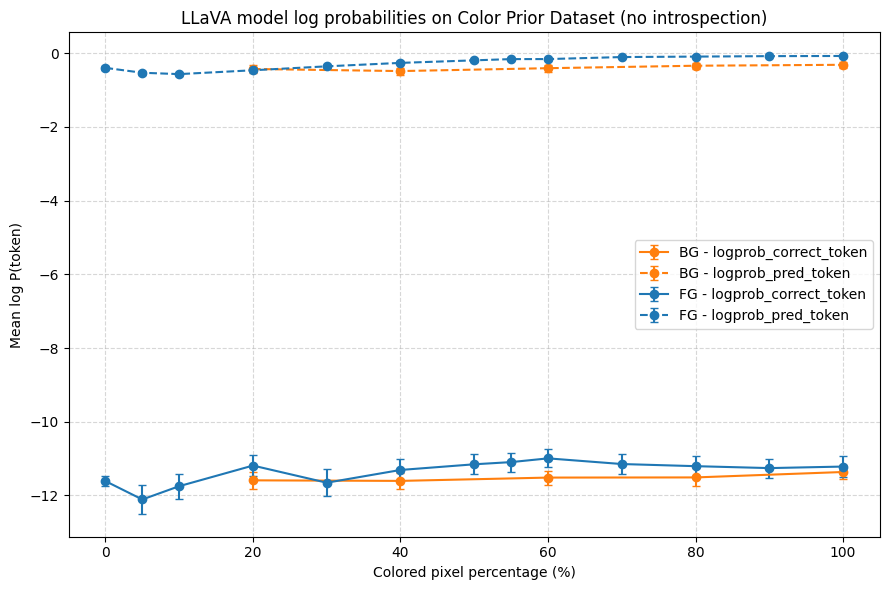

In [38]:
llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_image_priors.csv")
llava_prior_pred_df["response_label"] = llava_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
llava_prior_pred_df["intro_position"] = "last"
llava_prior_pred_df = llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(llava_prior_pred_df)

plot_fg_response_frequencies_bar(llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (no introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (no introspection)", response_col="response_label")

plot_model_logprobs(
    llava_prior_pred_df,
    title="LLaVA model log probabilities on Color Prior Dataset (no introspection)",
)

## 1.2.2 Color Prior Dataset with Introspection Question (LLaVA-NeXT)

In [11]:
suffix = "image_priors"
introsp_llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    calibration_value=llava_threshold,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [17:37<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.520403,-11.028215,False,50,50,white,first,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-1.085430,-11.108868,False,50,50,red,first,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.038748,-11.218436,False,50,50,red,first,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.184376,-13.801563,False,50,50,grey,first,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.220732,-10.244170,False,50,50,brown,first,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.162086,-8.810523,False,50,50,purple,first,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.550447,-12.089509,False,50,50,black,first,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.116080,-9.928580,False,50,50,brown,first,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.078677,-11.320865,False,50,50,green,first,correct_prior,green,green,FG,50,FG 50% (seq),seq


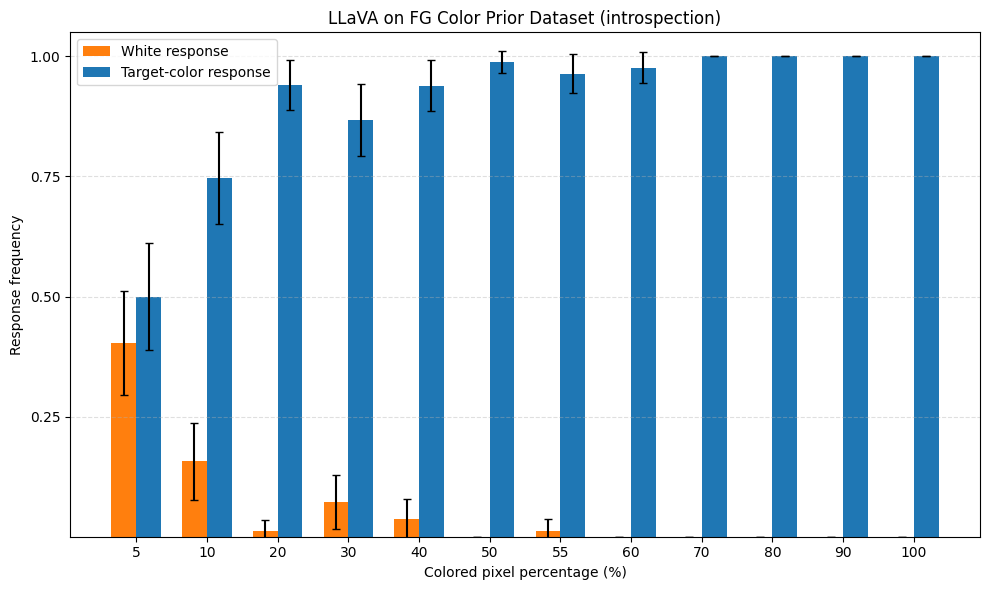

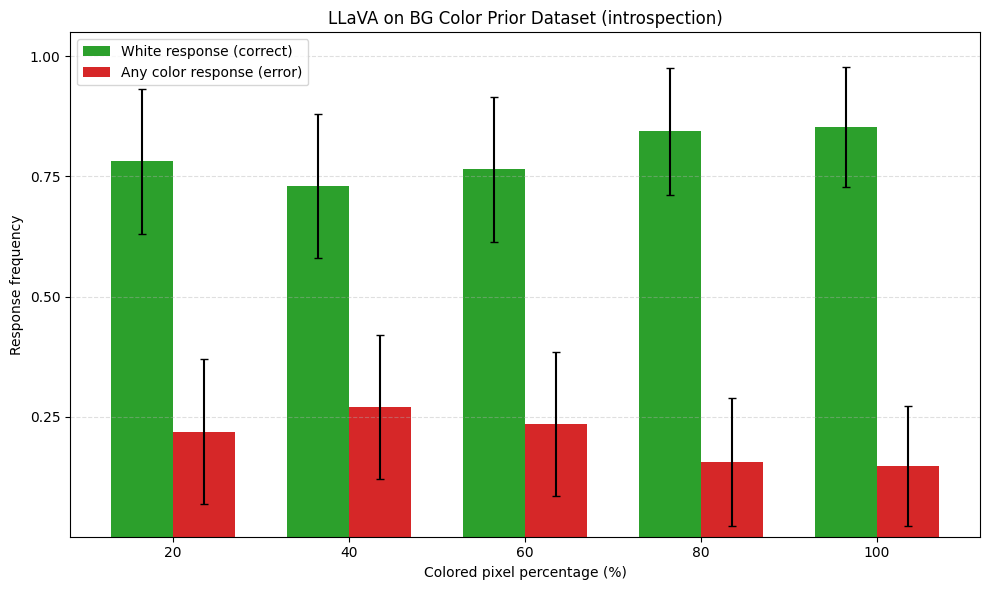

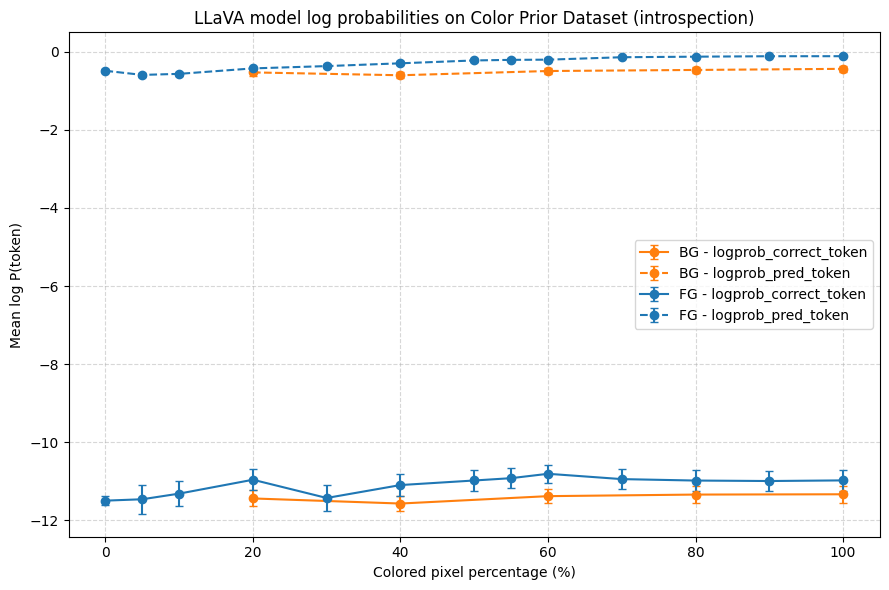

In [39]:
introsp_llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_image_priors.csv")
introsp_llava_prior_pred_df["response_label"] = introsp_llava_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_llava_prior_pred_df["intro_position"] = "first"
introsp_llava_prior_pred_df = introsp_llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_llava_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (introspection)", response_col="response_label")

plot_model_logprobs(
    introsp_llava_prior_pred_df,
    title="LLaVA model log probabilities on Color Prior Dataset (introspection)",
)

## 1.3.1. Counterfact Color Dataset (LLaVA-NeXT)

In [12]:
suffix = "counterfact"
llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_cf_pred_df.to_csv(out_path, index=False)

Evaluating counterfact object colors (counterfact stimuli): 100%|██████████| 412/412 [05:47<00:00,  1.18it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.008931,-10.633931,False,NaN,blue,last,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.038745,-9.694995,False,NaN,purple,last,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.298155,-10.704405,False,NaN,orange,last,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.289183,-11.664184,False,NaN,red,last,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.551923,-12.075361,False,NaN,white,last,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.134755,-10.869130,False,NaN,orange,last,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.947944,-10.635445,False,NaN,black,last,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.333490,-9.778803,False,NaN,purple,last,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.052415,-11.278977,False,NaN,green,last,counterfact,green,green,FG,70,FG 70% (seq),seq


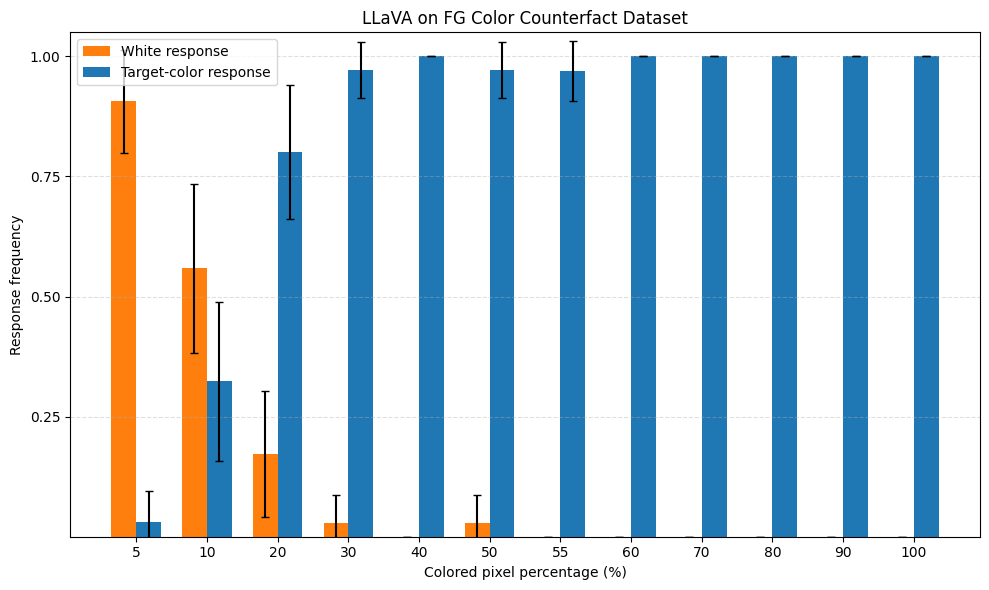

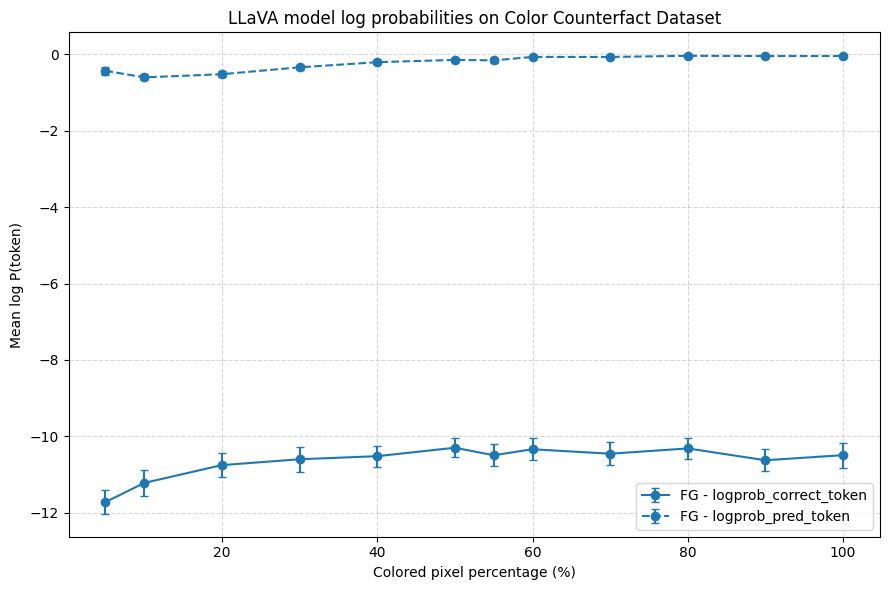

In [40]:
llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv")
llava_cf_pred_df["response_label"] = llava_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
llava_cf_pred_df["intro_position"] = "last"
llava_cf_pred_df = llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(llava_cf_pred_df)

plot_fg_response_frequencies_bar(llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset", response_col="response_label")
plot_model_logprobs(
    llava_cf_pred_df,
    title="LLaVA model log probabilities on Color Counterfact Dataset",
)

## 1.3.2. Counterfact Color Dataset with Introspection Question (LLaVA-NeXT)

In [13]:
suffix = "counterfact"
introsp_llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    calibration_value=llava_threshold,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_cf_pred_df.to_csv(out_path, index=False)

Evaluating counterfact object colors (counterfact stimuli): 100%|██████████| 412/412 [05:47<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.013361,-10.638361,False,50,50,blue,first,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.057854,-9.573479,False,50,50,purple,first,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.317456,-10.669019,False,50,50,orange,first,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.430259,-11.445884,False,50,50,red,first,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.584536,-12.002504,False,50,50,white,first,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.122223,-10.622223,False,50,50,orange,first,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.987835,-10.425335,False,50,50,black,first,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.333005,-9.739255,False,50,50,purple,first,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.083318,-11.067693,False,50,50,green,first,counterfact,green,green,FG,70,FG 70% (seq),seq


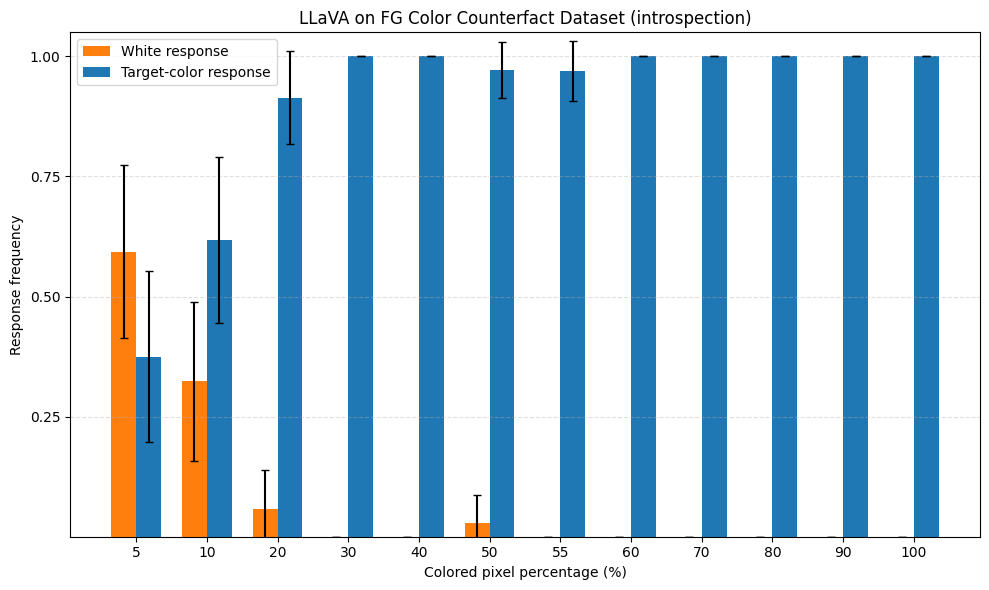

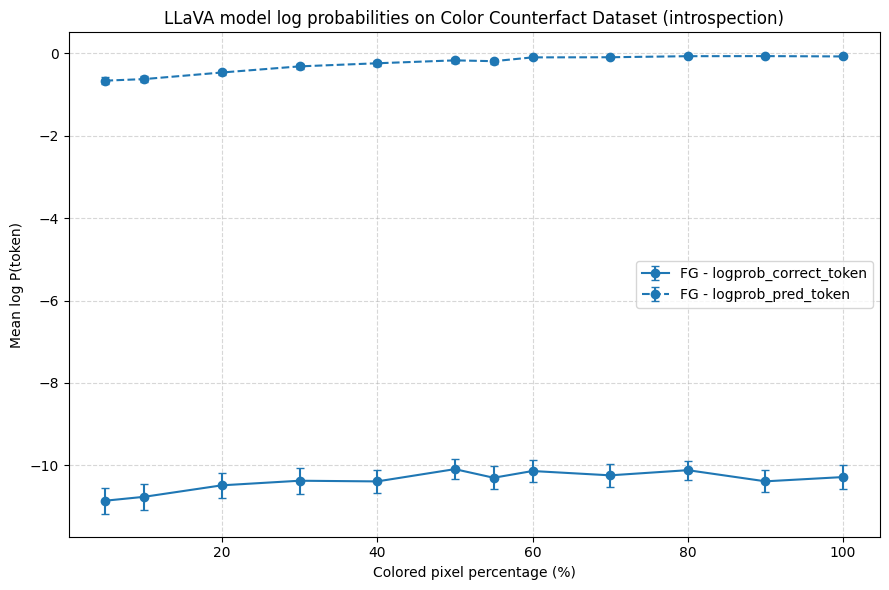

In [41]:
introsp_llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_counterfact.csv")
introsp_llava_cf_pred_df["response_label"] = introsp_llava_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_llava_cf_pred_df["intro_position"] = "first"
introsp_llava_cf_pred_df = introsp_llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_llava_cf_pred_df)

plot_fg_response_frequencies_bar(introsp_llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset (introspection)", response_col="response_label")
plot_model_logprobs(
    introsp_llava_cf_pred_df,
    title="LLaVA model log probabilities on Color Counterfact Dataset (introspection)",
)

## 1.4.1. Shape Dataset (LLaVA-NeXT)

In [14]:
suffix = "shapes"
llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_shape_pred_df.to_csv(out_path, index=False)

Evaluating shapes: 100%|██████████| 1331/1331 [18:38<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.107691,-10.045191,False,NaN,yellow,last,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.102478,-9.297791,False,NaN,purple,last,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.428803,-11.460052,False,NaN,white,last,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.186779,-10.139904,False,NaN,brown,last,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.138488,-10.529114,False,NaN,orange,last,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.377331,-13.971081,False,NaN,grey,last,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.159832,-10.464520,False,NaN,brown,last,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.287228,-12.123166,False,NaN,black,last,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.241936,-10.976311,False,NaN,white,last,shape,red,white,BG,40,BG 40% (seq),seq


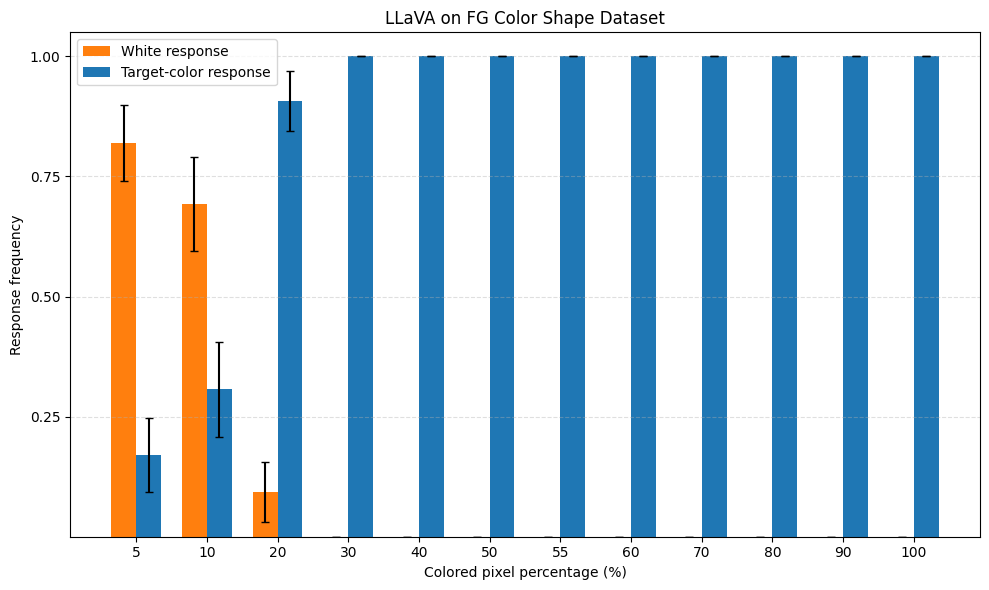

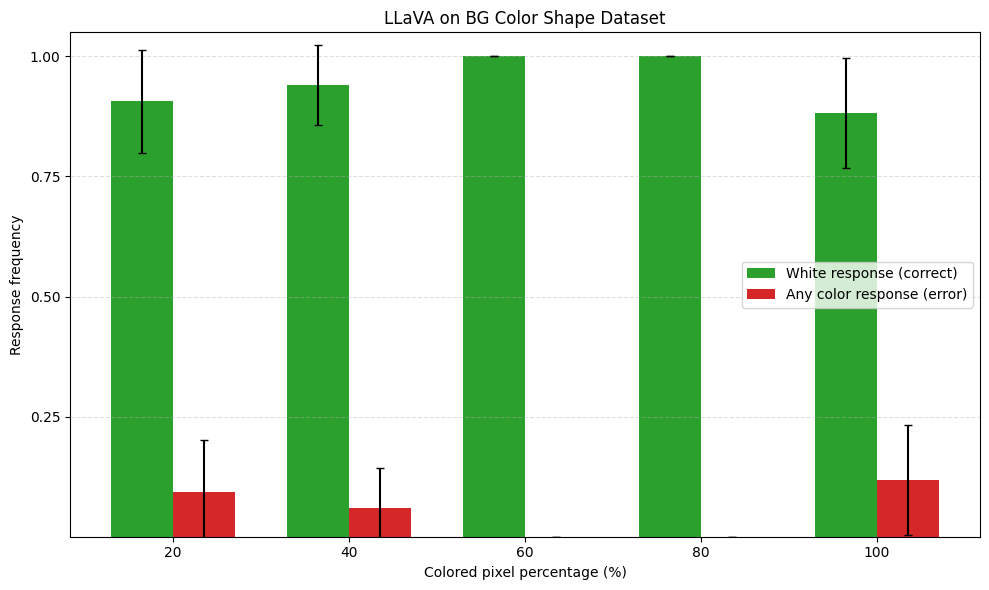

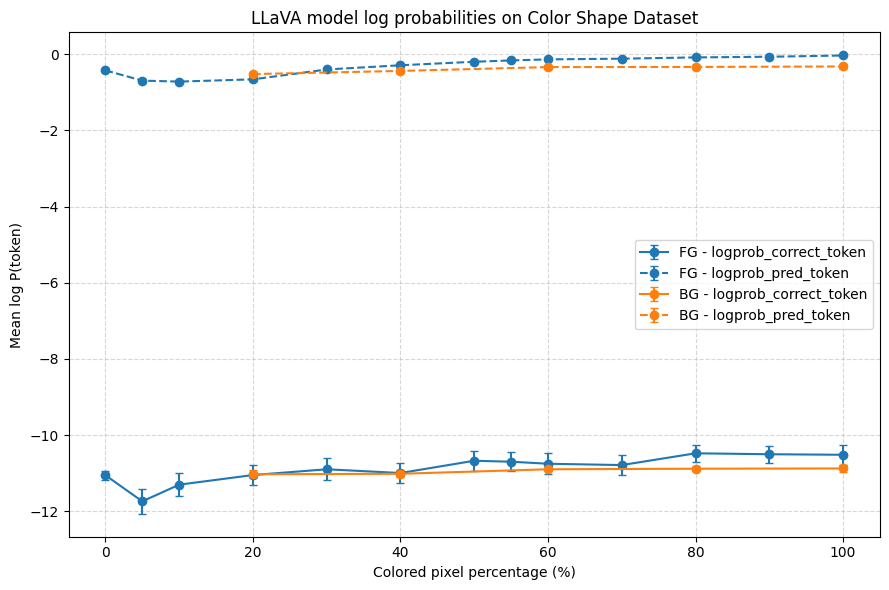

In [42]:
llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_shapes.csv")
llava_shape_pred_df["response_label"] = llava_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
llava_shape_pred_df["intro_position"] = "last"
llava_shape_pred_df = llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(llava_shape_pred_df)

plot_fg_response_frequencies_bar(llava_shape_pred_df, title="LLaVA on FG Color Shape Dataset", response_col="response_label")
plot_bg_response_frequencies_bar(llava_shape_pred_df, title="LLaVA on BG Color Shape Dataset", response_col="response_label")

plot_model_logprobs(
    llava_shape_pred_df,
    title="LLaVA model log probabilities on Color Shape Dataset",
)

## 1.4.2. Shape Dataset with Introspection (LLaVA-NeXT)

In [15]:
suffix = "shapes"
introsp_llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
    calibration_value=llava_threshold,
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_shape_pred_df.to_csv(out_path, index=False)

Evaluating shapes: 100%|██████████| 1331/1331 [18:49<00:00,  1.18it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.094827,-9.922953,False,50,50,yellow,first,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.085552,-9.335552,False,50,50,purple,first,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,blue,-0.735709,-10.766959,False,50,50,blue,first,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.166636,-10.026011,False,50,50,brown,first,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.170899,-10.319337,False,50,50,orange,first,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.329158,-13.735408,False,50,50,grey,first,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.097258,-10.355070,False,50,50,brown,first,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.311987,-11.546362,False,50,50,black,first,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.235297,-10.438422,False,50,50,white,first,shape,red,white,BG,40,BG 40% (seq),seq


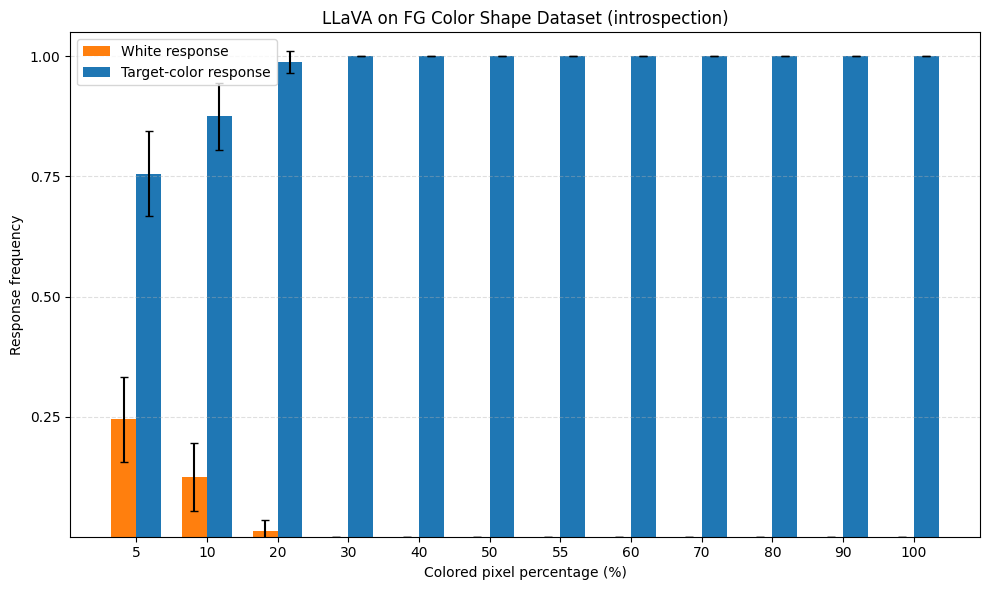

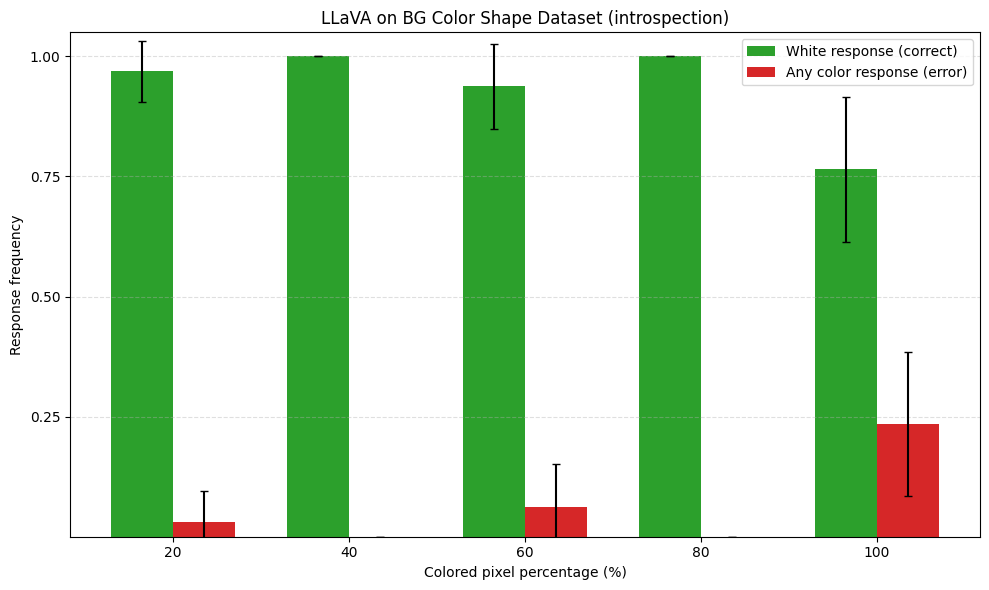

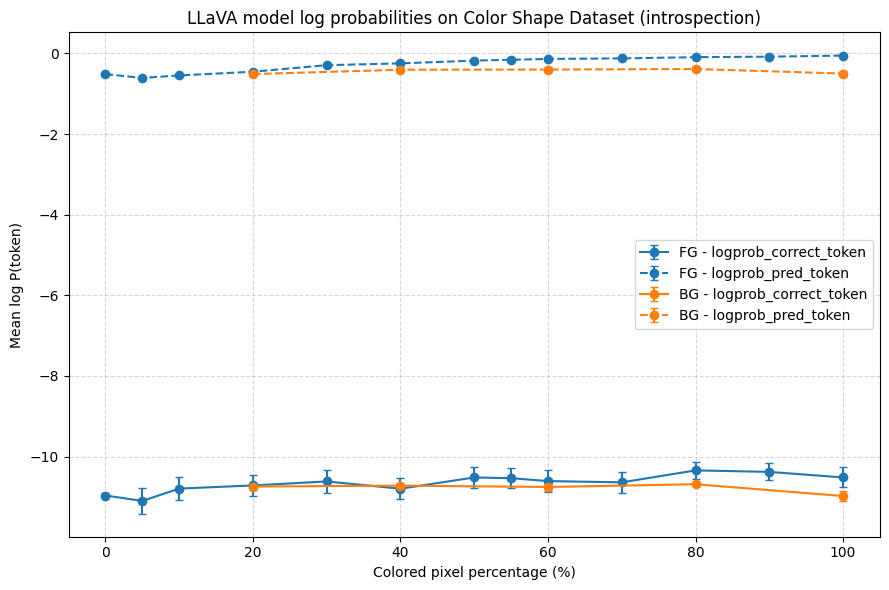

In [43]:
introsp_llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_shapes.csv")
introsp_llava_shape_pred_df["response_label"] = introsp_llava_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_llava_shape_pred_df["intro_position"] = "first"
introsp_llava_shape_pred_df = introsp_llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_llava_shape_pred_df)

plot_fg_response_frequencies_bar(introsp_llava_shape_pred_df, title="LLaVA on FG Color Shape Dataset (introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_llava_shape_pred_df, title="LLaVA on BG Color Shape Dataset (introspection)", response_col="response_label")

plot_model_logprobs(
    introsp_llava_shape_pred_df,
    title="LLaVA model log probabilities on Color Shape Dataset (introspection)",
)

In [45]:
# Combine all LLaVA results into one dataframe for easier comparison and plotting
llava_combined_df = pd.concat(
    [
        llava_prior_pred_df,
        introsp_llava_prior_pred_df,
        llava_cf_pred_df,
        introsp_llava_cf_pred_df,
        llava_shape_pred_df,
        introsp_llava_shape_pred_df,
    ],
    ignore_index=True
)

llava_combined_df = llava_combined_df.drop(columns=["calibration_threshold", "prob_correct_this"], errors="ignore")
display(llava_combined_df)

llava_combined_df.to_csv(LLAVA / f"evaluation_{llava_model_name}_combined.csv", index=False)

,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.256501,-10.654939,False,NaN,white,last,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,-1.101001,-12.749438,False,NaN,black,last,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.028346,-11.536159,False,NaN,red,last,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.142373,-14.216591,False,NaN,grey,last,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.161806,-10.232119,False,NaN,brown,last,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.329158,-13.735408,False,50.0,grey,first,shape,grey,grey,FG,40,FG 40% (seq),seq
6002,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.097258,-10.355070,False,50.0,brown,first,shape,brown,brown,FG,70,FG 70% (seq),seq
6003,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.311987,-11.546362,False,50.0,black,first,shape,blue,white,FG,0,FG 0% (seq),seq
6004,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.235297,-10.438422,False,50.0,white,first,shape,red,white,BG,40,BG 40% (seq),seq


# 2. GPT-4o

In [10]:
gpt_model_name = "gpt-4o"
backend = "gpt4"
GPT = DATA / "GPT_results"
GPT.mkdir(parents=True, exist_ok=True)

## 2.1. Introspection question (GPT-4o)

In [12]:
calibration = ask_vlm_introspection_threshold(
    backend="gpt",
    model_name=gpt_model_name,
)

gpt_threshold = calibration["introspection_threshold"]
gpt_raw = calibration["introspection_raw"]
print(gpt_raw)
print(gpt_threshold)

50
50


## 2.2.1. Color Prior Dataset (GPT-4o)

In [9]:
suffix = "image_priors"
gpt_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1260/1260 [20:51<00:00,  1.01it/s] 


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,black,-0.893953,-1.393953,True,NaN,NaN,black,last,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,-0.318641,NaN,False,NaN,NaN,black,last,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.000585,-0.000585,True,NaN,NaN,red,last,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.004357,-0.004357,True,NaN,NaN,grey,last,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.000067,-0.000067,True,NaN,NaN,brown,last,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.001748,-0.001748,True,NaN,NaN,purple,last,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.000601,-9.750601,True,NaN,NaN,black,last,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.025134,-0.025134,True,NaN,NaN,brown,last,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.000194,-0.000194,True,NaN,NaN,green,last,correct_prior,green,green,FG,50,FG 50% (seq),seq


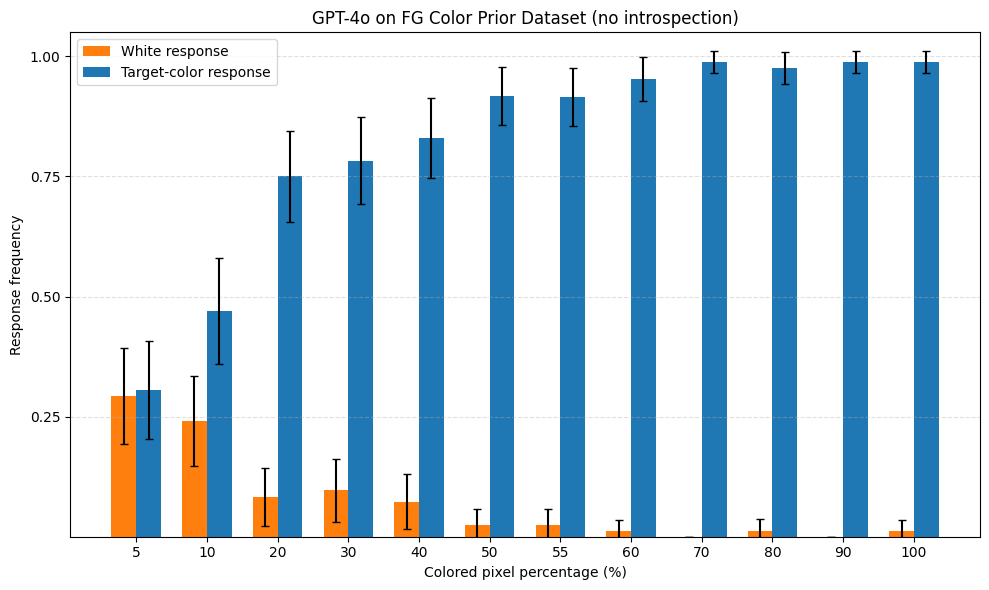

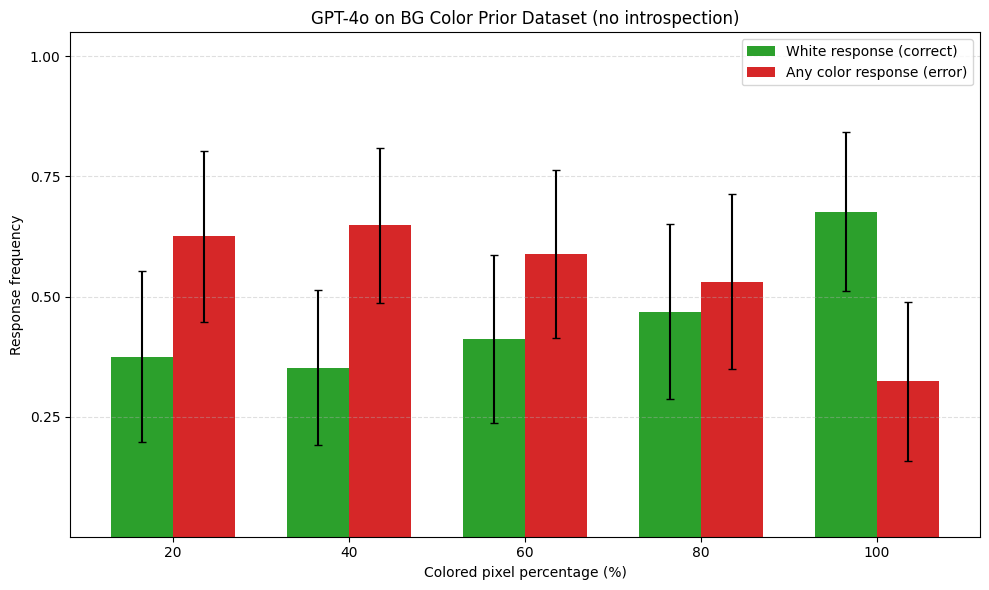

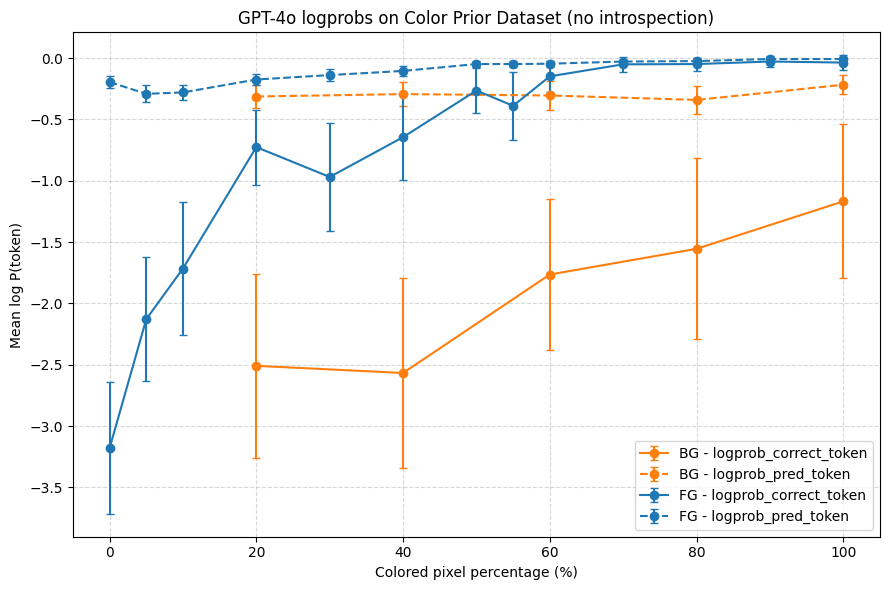

In [11]:
gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_image_priors.csv")
gpt_prior_pred_df["response_label"] = gpt_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
gpt_prior_pred_df["intro_position"] = "last"
gpt_prior_pred_df = gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(gpt_prior_pred_df)

plot_fg_response_frequencies_bar(gpt_prior_pred_df, title="GPT-4o on FG Color Prior Dataset (no introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(gpt_prior_pred_df, title="GPT-4o on BG Color Prior Dataset (no introspection)", response_col="response_label")

plot_model_logprobs(
    gpt_prior_pred_df,
    title="GPT-4o logprobs on Color Prior Dataset (no introspection)"
)

## 2.2.2 Color Prior Dataset with Introspection Question (GPT-4o)

In [10]:
suffix = "image_priors"
introsp_gpt_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None
)

out_path = GPT / f"evaluation_introsp_{gpt_model_name}_{suffix}.csv"
introsp_gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1260/1260 [23:59<00:00,  1.14s/it] 


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.033763,-0.033763,True,NaN,60,white,first,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,white,-0.508399,NaN,False,NaN,60,white,first,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.000023,-0.000023,True,NaN,60,red,first,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.018361,-0.018361,True,NaN,60,grey,first,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.003580,-0.003580,True,NaN,60,brown,first,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,white,-0.855955,-0.855955,True,NaN,60,white,first,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.002821,-6.252821,True,NaN,60,black,first,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.080644,-0.080644,True,NaN,60,brown,first,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.012303,-0.012303,True,NaN,60,green,first,correct_prior,green,green,FG,50,FG 50% (seq),seq


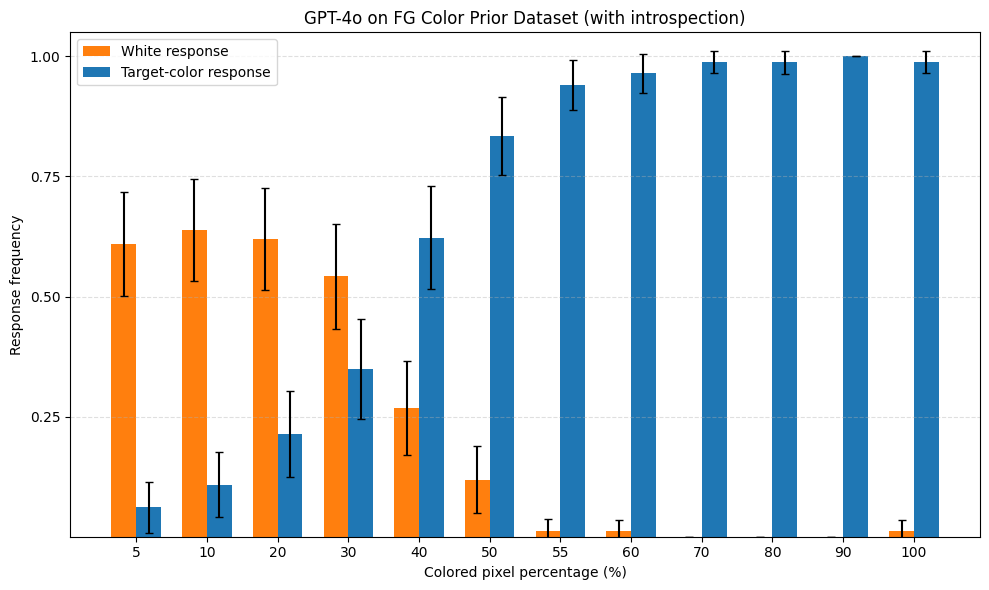

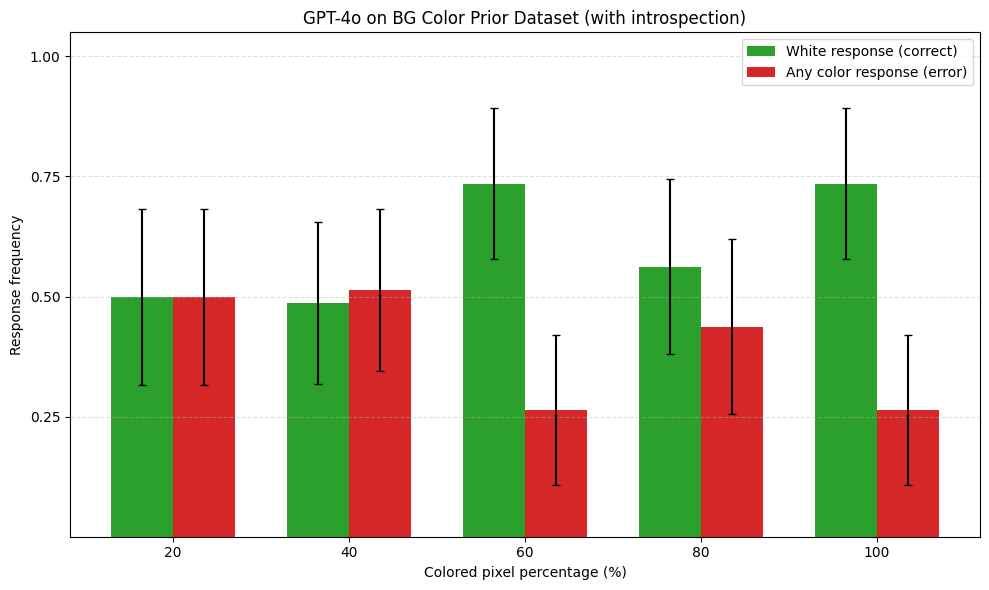

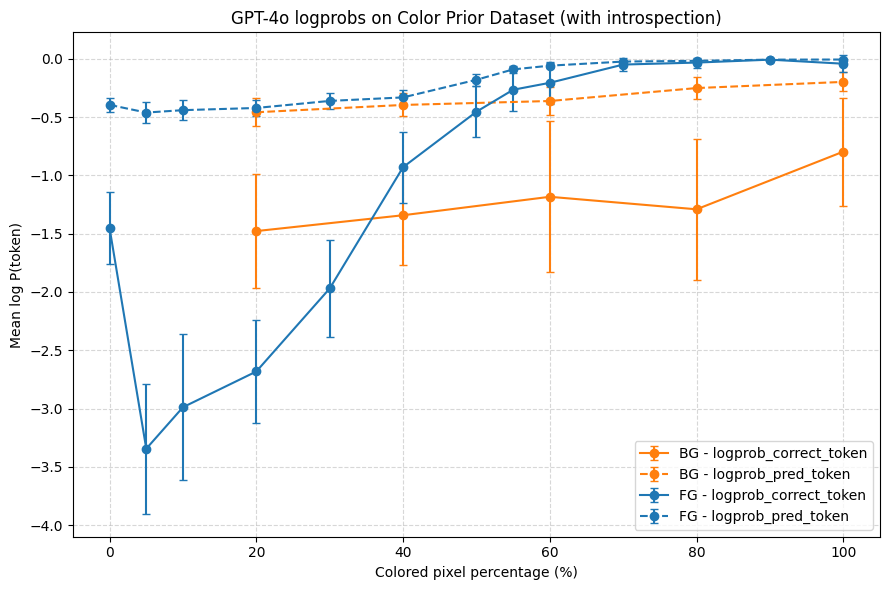

In [13]:
introsp_gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_image_priors.csv")
introsp_gpt_prior_pred_df["response_label"] = introsp_gpt_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_prior_pred_df["intro_position"] = "first"
introsp_gpt_prior_pred_df = introsp_gpt_prior_pred_df.drop(columns=["calibration_threshold"])
introsp_gpt_prior_pred_df = introsp_gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_gpt_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_prior_pred_df, title="GPT-4o on FG Color Prior Dataset (with introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_gpt_prior_pred_df, title="GPT-4o on BG Color Prior Dataset (with introspection)", response_col="response_label")

plot_model_logprobs(
    introsp_gpt_prior_pred_df,
    title="GPT-4o logprobs on Color Prior Dataset (with introspection)"
)

## 2.2.3 Color Prior Dataset with Multi-Turn Introspection Question (GPT-4o)

In [45]:
suffix = "image_priors"
mult_introsp_gpt_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None,
    multiturn_introspection=True,
)

out_path = GPT / f"evaluation_mult_introsp_{gpt_model_name}_{suffix}.csv"
mult_introsp_gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1260/1260 [25:11<00:00,  1.20s/it]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,yellow,-0.018523,-4.018523,True,50,yellow,multiturn,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,silver,-0.556494,NaN,False,50,other,multiturn,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.000177,-0.000177,True,50,red,multiturn,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.001480,-0.001480,True,50,grey,multiturn,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.000020,-0.000020,True,50,brown,multiturn,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.000250,-0.000250,True,50,purple,multiturn,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black-and-white,-0.000063,-12.250063,True,50,white,multiturn,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.004347,-0.004347,True,50,brown,multiturn,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.000247,-0.000247,True,50,green,multiturn,correct_prior,green,green,FG,50,FG 50% (seq),seq


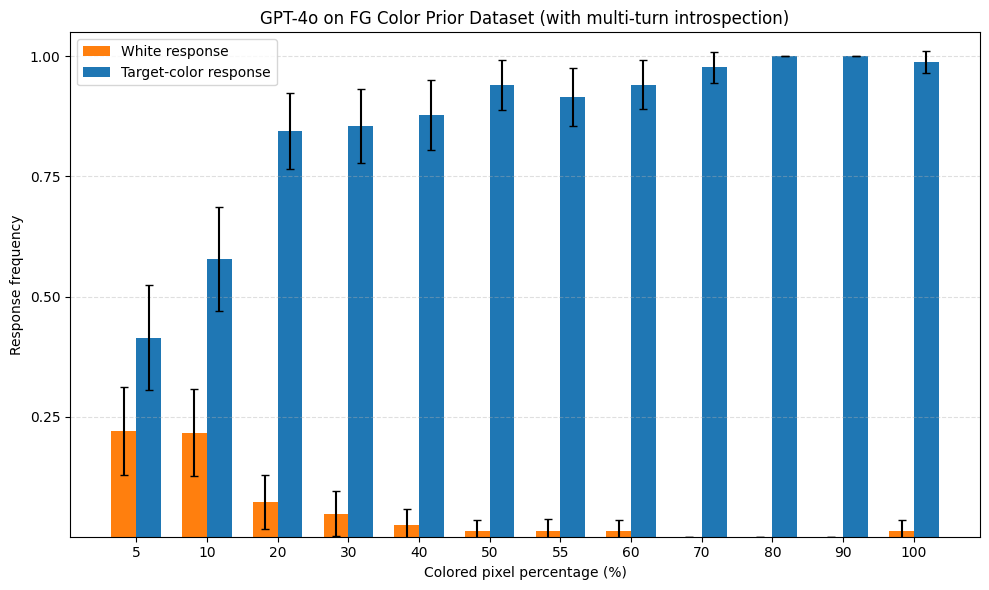

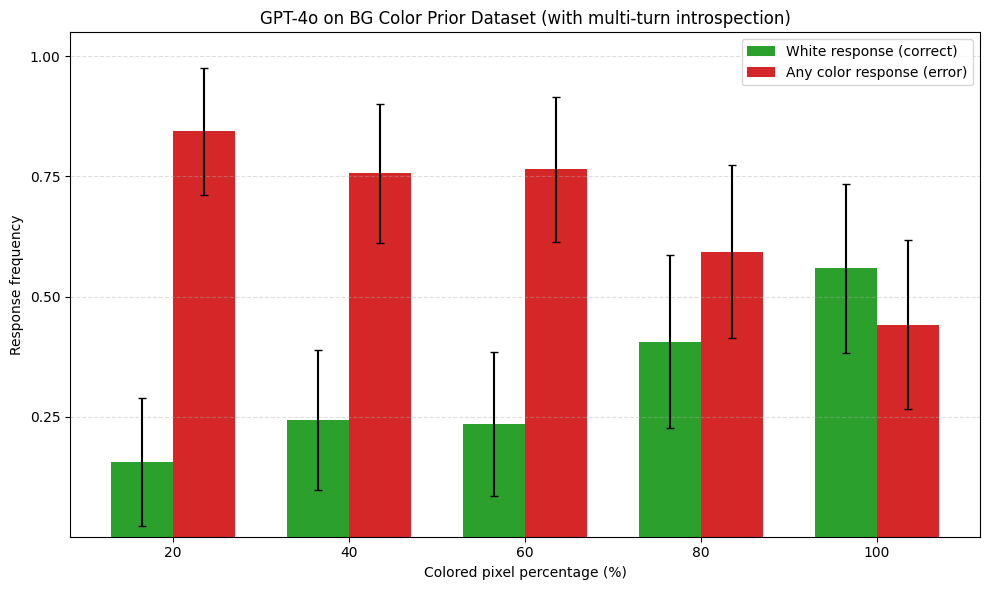

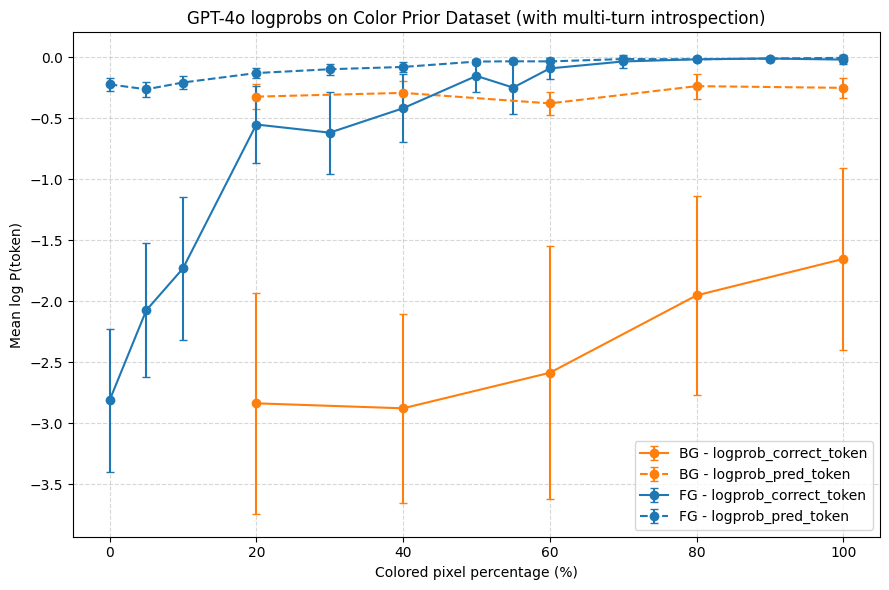

In [14]:
mult_introsp_gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_mult_introsp_gpt-4o_image_priors.csv")
mult_introsp_gpt_prior_pred_df["response_label"] = mult_introsp_gpt_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
mult_introsp_gpt_prior_pred_df["intro_position"] = "multiturn"
mult_introsp_gpt_prior_pred_df = mult_introsp_gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(mult_introsp_gpt_prior_pred_df)

plot_fg_response_frequencies_bar(mult_introsp_gpt_prior_pred_df, title="GPT-4o on FG Color Prior Dataset (with multi-turn introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(mult_introsp_gpt_prior_pred_df, title="GPT-4o on BG Color Prior Dataset (with multi-turn introspection)", response_col="response_label")

plot_model_logprobs(
    mult_introsp_gpt_prior_pred_df,
    title="GPT-4o logprobs on Color Prior Dataset (with multi-turn introspection)"
)

## 2.3.1. Counterfact Color Dataset (GPT-4o)

In [28]:
suffix = "counterfact"
gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [08:29<00:00,  1.24s/it]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.000057,-0.000057,True,NaN,NaN,blue,last,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.001990,-0.001990,True,NaN,NaN,purple,last,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,black,-1.084120,-1.584120,True,NaN,NaN,black,last,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.008513,-0.008513,True,NaN,NaN,red,last,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,black,-0.541036,-3.541036,True,NaN,NaN,black,last,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.070576,-0.070576,True,NaN,NaN,orange,last,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.083677,-2.583677,True,NaN,NaN,black,last,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.346775,-0.346775,True,NaN,NaN,purple,last,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.000622,-0.000622,True,NaN,NaN,green,last,counterfact,green,green,FG,70,FG 70% (seq),seq


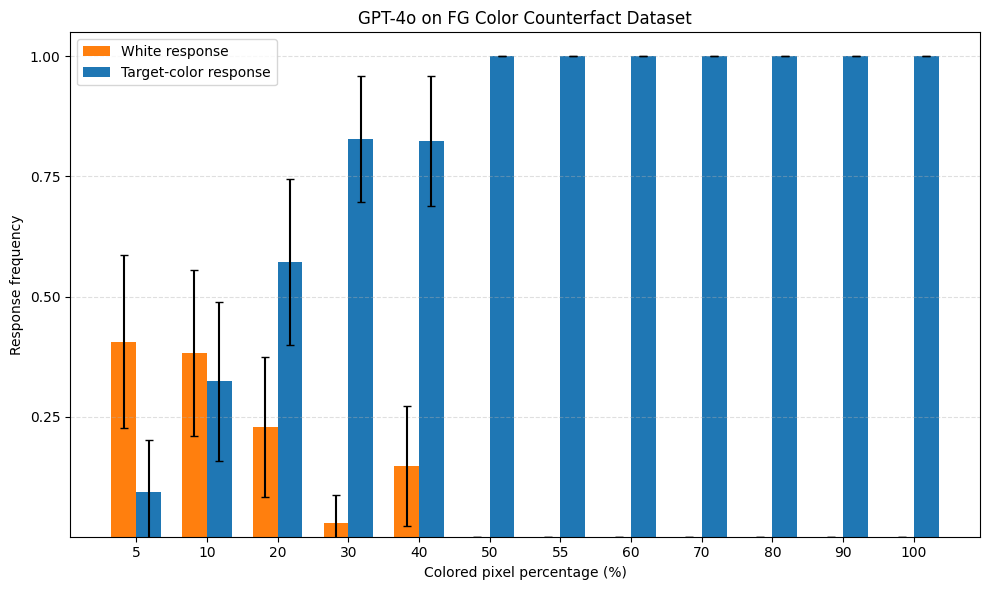

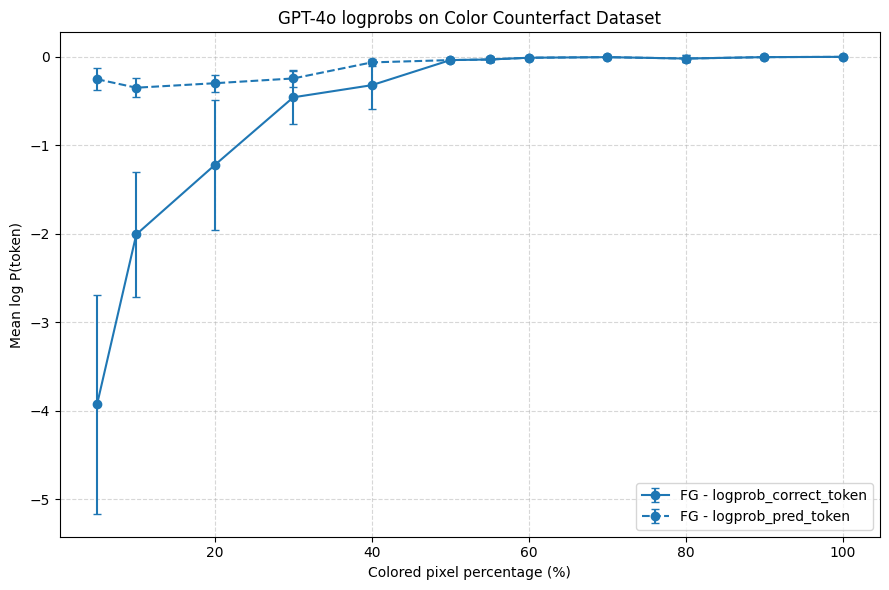

In [19]:
gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_counterfact.csv")
gpt_cf_pred_df["response_label"] = gpt_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
gpt_cf_pred_df["intro_position"] = "last"
gpt_cf_pred_df = gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(gpt_cf_pred_df)

plot_fg_response_frequencies_bar(gpt_cf_pred_df, title="GPT-4o on FG Color Counterfact Dataset", response_col="response_label")
plot_model_logprobs(
    gpt_cf_pred_df,
    title="GPT-4o logprobs on Color Counterfact Dataset"
)

## 2.3.2. Counterfact Color Dataset with Introspection Question (GPT-4o)

In [12]:
suffix = "counterfact"
introsp_gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None
)

out_path = GPT / f"evaluation_introsp_{gpt_model_name}_{suffix}.csv"
introsp_gpt_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [07:33<00:00,  1.10s/it]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.000158,-0.000158,True,NaN,60,60,blue,first,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.033372,-0.033372,True,NaN,60,60,purple,first,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,uncolored,-0.637780,NaN,False,NaN,60,60,white,first,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.492006,-0.492006,True,NaN,60,60,red,first,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.358402,-5.358402,True,NaN,60,60,white,first,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,white,-0.170573,-3.920573,True,NaN,60,60,white,first,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.075540,-3.825540,True,NaN,60,60,black,first,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.717668,-0.717668,True,NaN,60,60,purple,first,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.002412,-0.002412,True,NaN,60,60,green,first,counterfact,green,green,FG,70,FG 70% (seq),seq


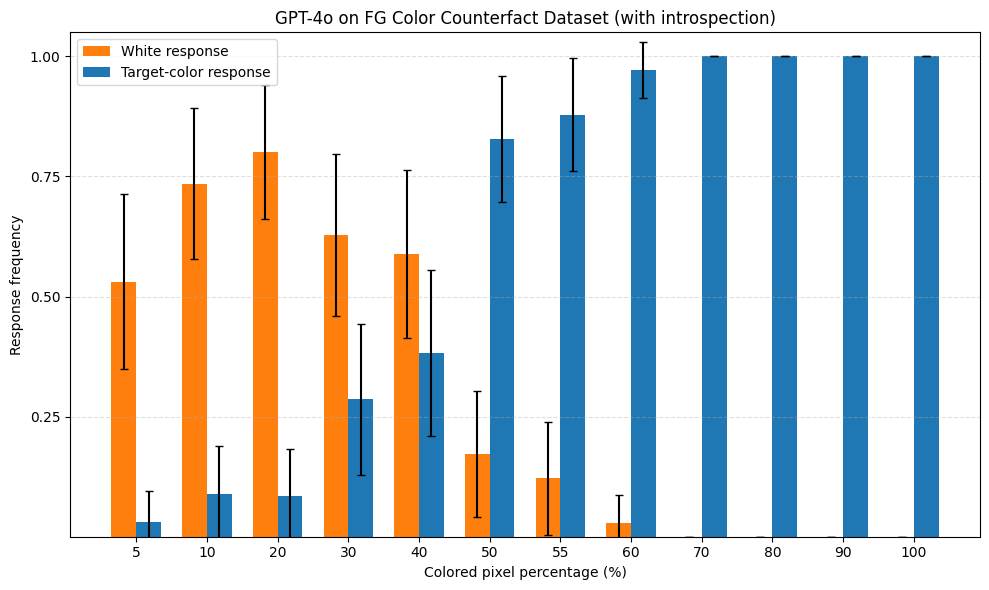

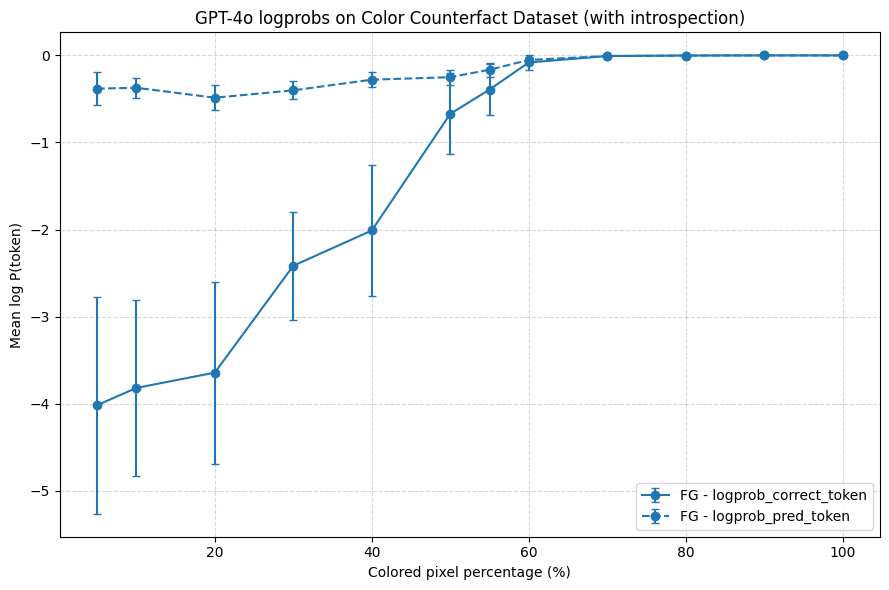

In [20]:
introsp_gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_counterfact.csv")
introsp_gpt_cf_pred_df["response_label"] = introsp_gpt_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_cf_pred_df["intro_position"] = "first"
introsp_gpt_cf_pred_df = introsp_gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_gpt_cf_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_cf_pred_df, title="GPT-4o on FG Color Counterfact Dataset (with introspection)", response_col="response_label")
plot_model_logprobs(
    introsp_gpt_cf_pred_df,
    title="GPT-4o logprobs on Color Counterfact Dataset (with introspection)"
)

## 2.3.3. Counterfact Color Dataset with Multi-Turn Introspection Question (GPT-4o)

In [21]:
suffix = "counterfact"
mult_introsp_gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None,
    multiturn_introspection=True,
)

out_path = GPT / f"evaluation_mult_introsp_{gpt_model_name}_{suffix}.csv"
mult_introsp_gpt_cf_pred_df.to_csv(out_path, index=False)

NameError: name 'gpt_threshold' is not defined

,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.000013,-0.000013,True,50,blue,multiturn,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.001855,-0.001855,True,50,purple,multiturn,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.008114,-0.008114,True,50,orange,multiturn,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.003379,-0.003379,True,50,red,multiturn,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,black,-0.114245,-7.864245,True,50,black,multiturn,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.100721,-0.100721,True,50,orange,multiturn,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.007059,-5.007059,True,50,black,multiturn,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.035328,-0.035328,True,50,purple,multiturn,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.000004,-0.000004,True,50,green,multiturn,counterfact,green,green,FG,70,FG 70% (seq),seq


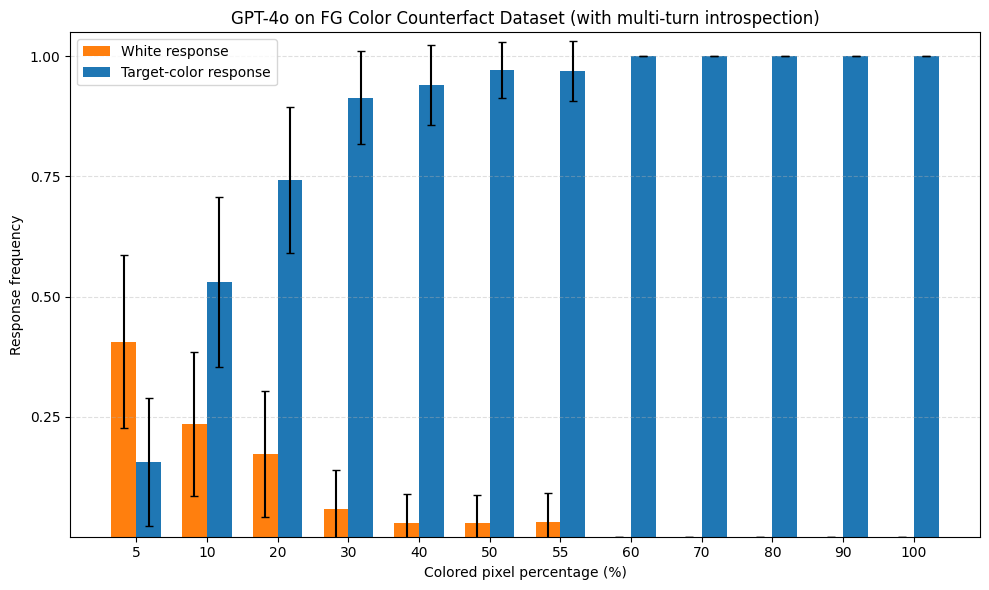

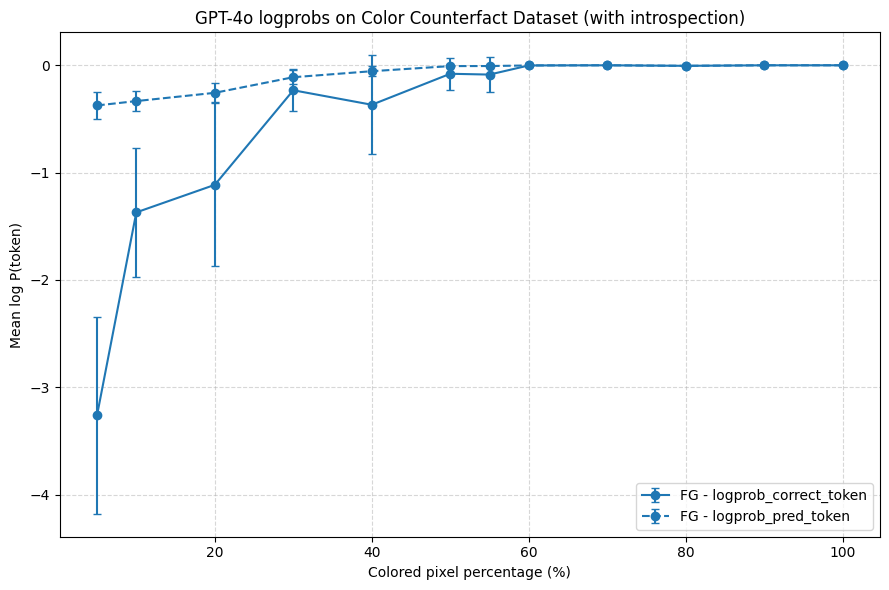

In [22]:
mult_introsp_gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_mult_introsp_gpt-4o_counterfact.csv")
mult_introsp_gpt_cf_pred_df["response_label"] = mult_introsp_gpt_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
mult_introsp_gpt_cf_pred_df["intro_position"] = "multiturn"
mult_introsp_gpt_cf_pred_df = mult_introsp_gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(mult_introsp_gpt_cf_pred_df)

plot_fg_response_frequencies_bar(mult_introsp_gpt_cf_pred_df, title="GPT-4o on FG Color Counterfact Dataset (with multi-turn introspection)", response_col="response_label")

plot_model_logprobs(
    mult_introsp_gpt_cf_pred_df,
    title="GPT-4o logprobs on Color Counterfact Dataset (with introspection)"
)

## 2.4.1. Shape Dataset (GPT-4o)

In [ ]:
suffix = "shapes"
gpt_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)
introsp_gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_image_priors.csv")
introsp_gpt_prior_pred_df["response_label"] = introsp_gpt_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_prior_pred_df["intro_position"] = "first"
introsp_gpt_prior_pred_df = introsp_gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_gpt_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_prior_pred_df, title="GPT-4o on FG Color Prior Dataset (with introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_gpt_prior_pred_df, title="GPT-4o on BG Color Prior Dataset (with introspection)", response_col="response_label")

plot_model_logprobs(
    introsp_gpt_prior_pred_df,
    title="GPT-4o logprobs on Color Prior Dataset (with introspection)"
)
out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [17:21<00:00,  1.28it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.000733,-0.000733,True,NaN,NaN,yellow,last,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.001189,-0.001189,True,NaN,NaN,purple,last,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.003022,-6.253022,True,NaN,NaN,white,last,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.002968,-0.002968,True,NaN,NaN,brown,last,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange.,-0.000303,-0.000303,True,NaN,NaN,orange,last,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.209264,-0.209264,True,NaN,NaN,grey,last,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.005000,-0.005000,True,NaN,NaN,brown,last,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.705035,-0.705035,True,NaN,NaN,white,last,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.000099,-0.000099,True,NaN,NaN,white,last,shape,red,white,BG,40,BG 40% (seq),seq


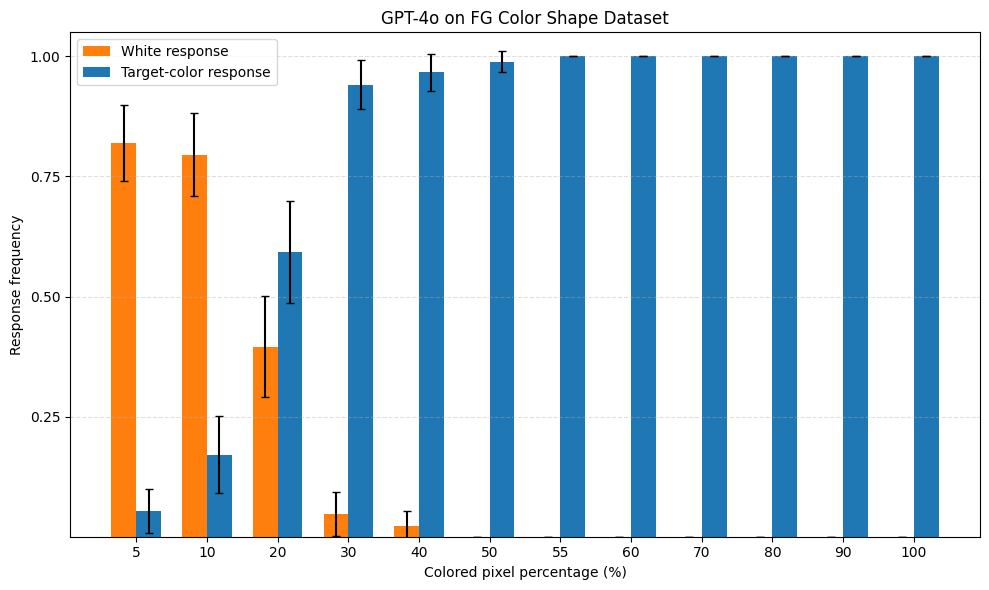

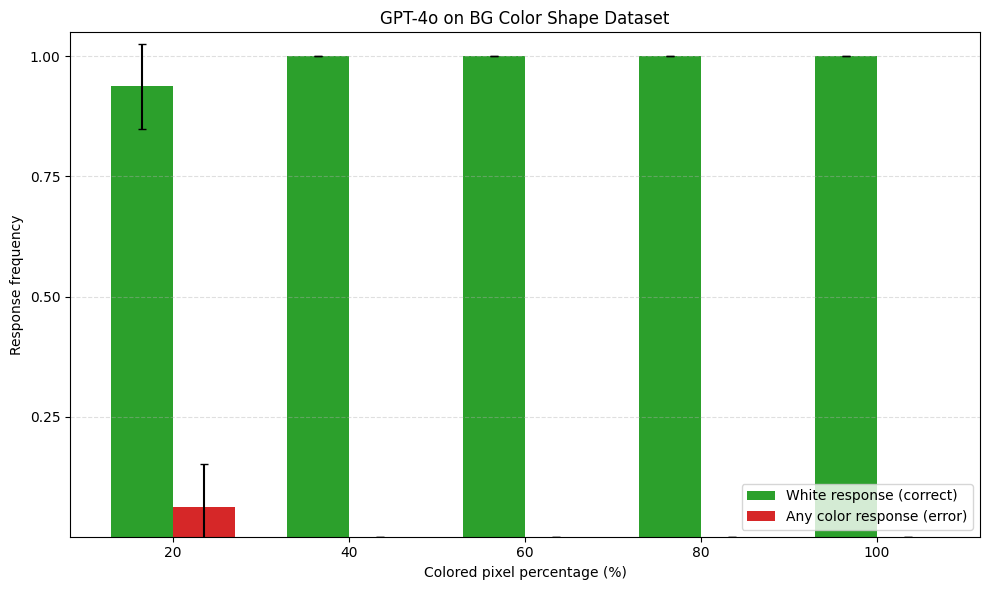

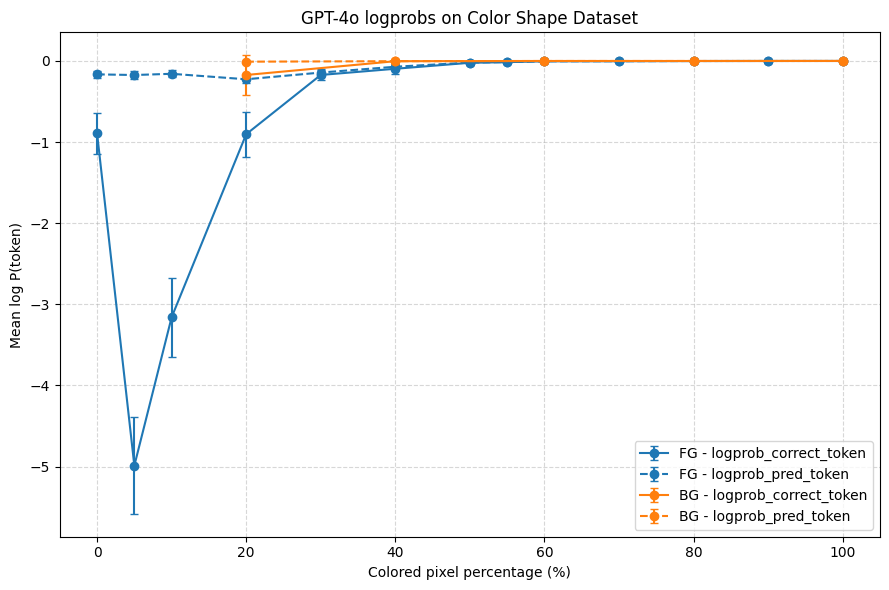

In [23]:
gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_shapes.csv")
gpt_shape_pred_df["response_label"] = gpt_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
gpt_shape_pred_df["intro_position"] = "last"
gpt_shape_pred_df = gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(gpt_shape_pred_df)

plot_fg_response_frequencies_bar(gpt_shape_pred_df, title="GPT-4o on FG Color Shape Dataset", response_col="response_label")
plot_bg_response_frequencies_bar(gpt_shape_pred_df, title="GPT-4o on BG Color Shape Dataset", response_col="response_label")

plot_model_logprobs(
    gpt_shape_pred_df,
    title="GPT-4o logprobs on Color Shape Dataset"
)

## 2.4.1. Shape Dataset with Introspection Question (GPT-4o)

In [41]:
suffix = "shapes"
introsp_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None)

out_path = GPT / f"evaluation_introsp_{gpt_model_name}_{suffix}.csv"
introsp_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [18:42<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.002674,-0.002674,True,NaN,60,60,yellow,first,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,white,-0.382449,-1.382449,True,NaN,60,60,white,first,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.003943,NaN,False,NaN,60,60,white,first,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.099861,-0.099861,True,NaN,60,60,brown,first,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.000016,-0.000016,True,NaN,60,60,orange,first,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,white,-0.131223,-2.131223,True,NaN,60,60,white,first,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.000063,-0.000063,True,NaN,60,60,brown,first,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.404295,-0.404295,True,NaN,60,60,white,first,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.000365,-0.000365,True,NaN,60,60,white,first,shape,red,white,BG,40,BG 40% (seq),seq


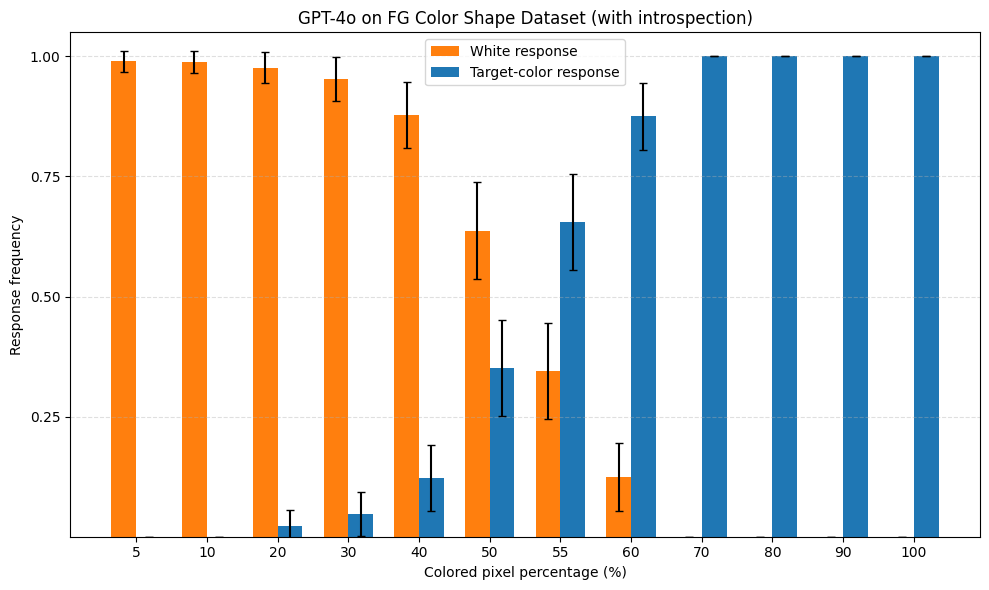

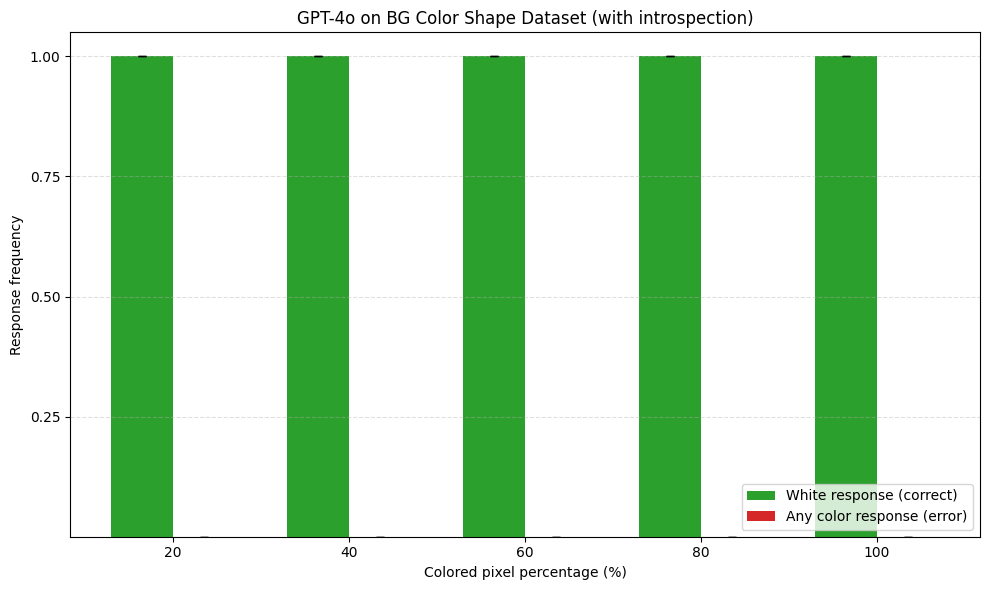

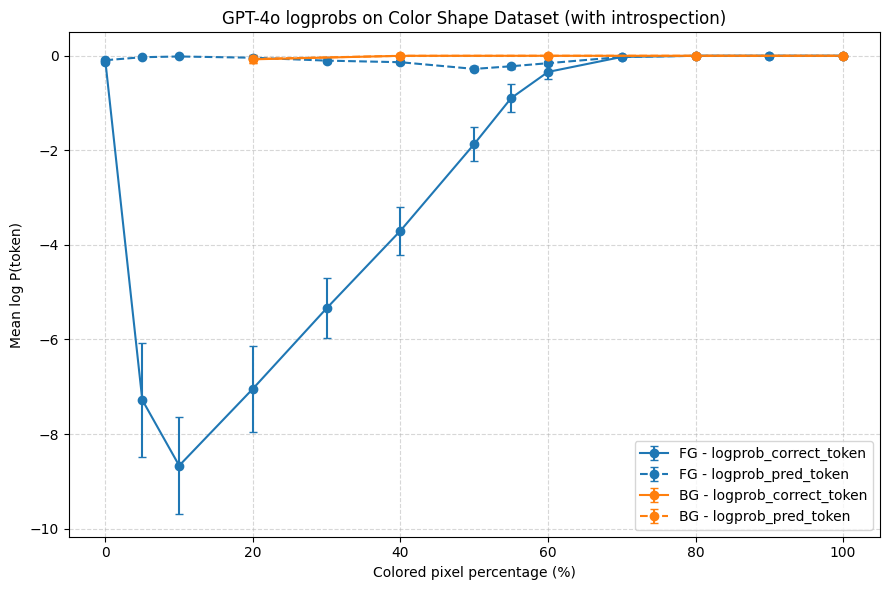

In [24]:
introsp_gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_shapes.csv")
introsp_gpt_shape_pred_df["response_label"] = introsp_gpt_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_shape_pred_df["intro_position"] = "first"
introsp_gpt_shape_pred_df = introsp_gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_gpt_shape_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_shape_pred_df, title="GPT-4o on FG Color Shape Dataset (with introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_gpt_shape_pred_df, title="GPT-4o on BG Color Shape Dataset (with introspection)", response_col="response_label")

plot_model_logprobs(
    introsp_gpt_shape_pred_df,
    title="GPT-4o logprobs on Color Shape Dataset (with introspection)"
)

## 2.4.1. Shape Dataset with Multi-Turn Introspection Question (GPT-4o)

In [49]:
suffix = "shapes"
mult_introsp_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None,
    multiturn_introspection=True
)

out_path = GPT / f"evaluation_mult_introsp_{gpt_model_name}_{suffix}.csv"
mult_introsp_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [19:20<00:00,  1.15it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.000013,-0.000013,True,50,yellow,multiturn,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.000212,-0.000212,True,50,purple,multiturn,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.001557,NaN,False,50,white,multiturn,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.000153,-0.000153,True,50,brown,multiturn,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.000005,-0.000005,True,50,orange,multiturn,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,white,-0.391100,-1.141100,True,50,white,multiturn,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.000055,-0.000055,True,50,brown,multiturn,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.479869,-0.979869,True,50,black,multiturn,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.000031,-0.000031,True,50,white,multiturn,shape,red,white,BG,40,BG 40% (seq),seq


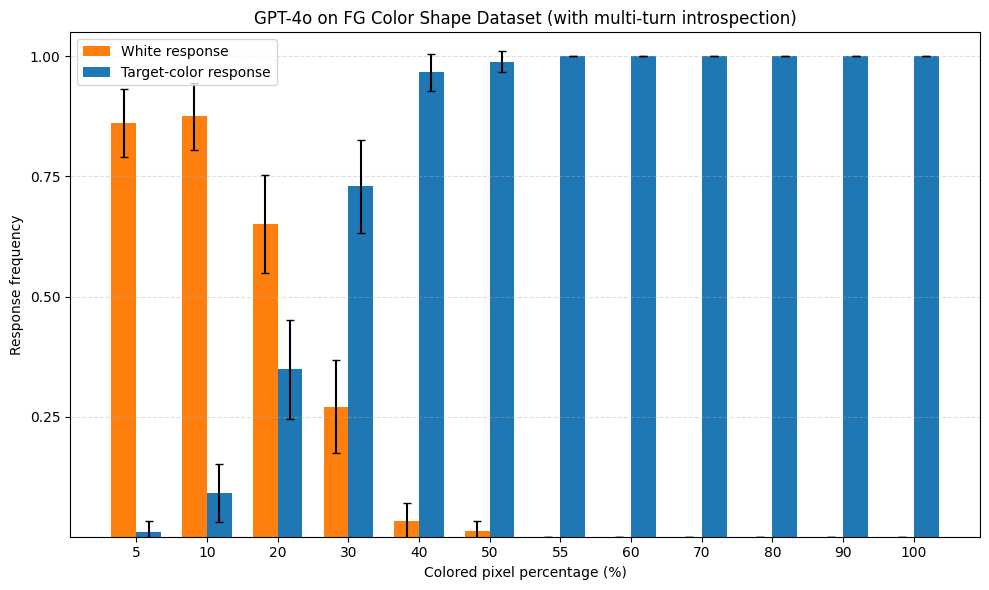

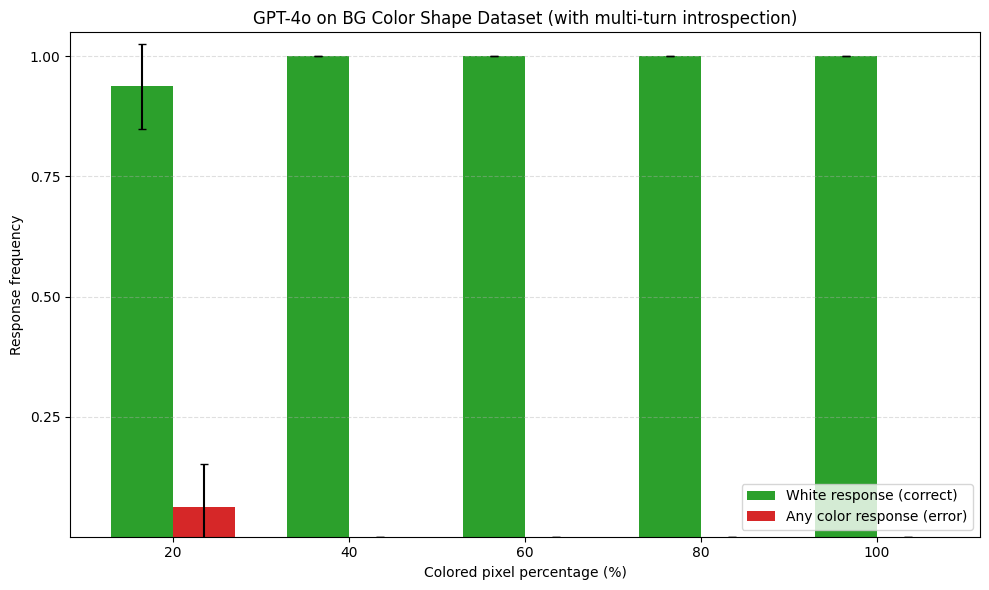

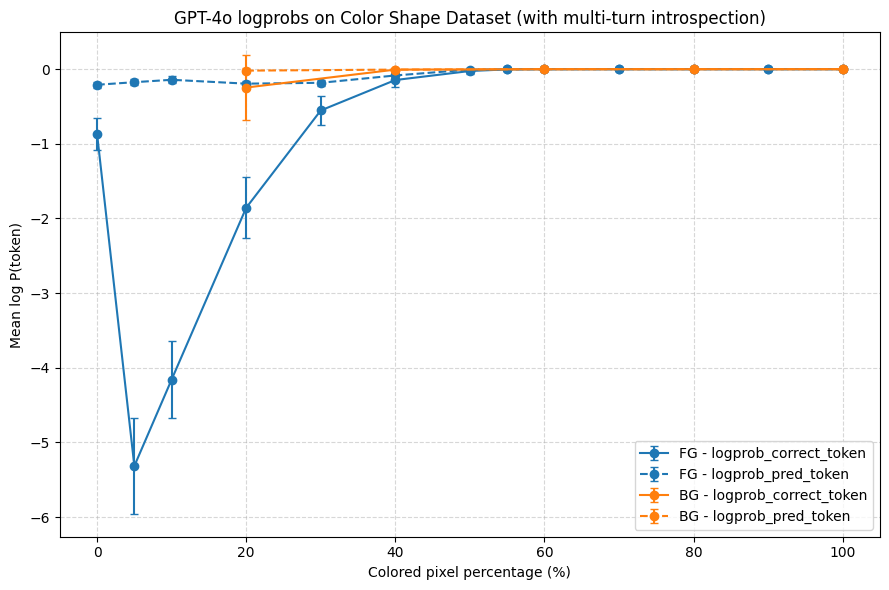

In [25]:
mult_introsp_gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_mult_introsp_gpt-4o_shapes.csv")
mult_introsp_gpt_shape_pred_df["response_label"] = mult_introsp_gpt_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
mult_introsp_gpt_shape_pred_df["intro_position"] = "multiturn"
mult_introsp_gpt_shape_pred_df = mult_introsp_gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(mult_introsp_gpt_shape_pred_df)
plot_fg_response_frequencies_bar(mult_introsp_gpt_shape_pred_df, title="GPT-4o on FG Color Shape Dataset (with multi-turn introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(mult_introsp_gpt_shape_pred_df, title="GPT-4o on BG Color Shape Dataset (with multi-turn introspection)", response_col="response_label")

plot_model_logprobs(
    mult_introsp_gpt_shape_pred_df,
    title="GPT-4o logprobs on Color Shape Dataset (with multi-turn introspection)"
)

In [28]:
# Combine all GPT results into one dataframe for easier comparison and plotting
gpt_combined_df = pd.concat(
    [
        gpt_prior_pred_df,
        introsp_gpt_prior_pred_df,
        gpt_cf_pred_df,
        introsp_gpt_cf_pred_df,
        gpt_shape_pred_df,
        introsp_gpt_shape_pred_df,
        mult_introsp_gpt_prior_pred_df,
        mult_introsp_gpt_cf_pred_df,
        mult_introsp_gpt_shape_pred_df,
    ],
    ignore_index=True
)
gpt_combined_df = gpt_combined_df.drop(columns=["calibration_threshold", "prob_correct_this"], errors="ignore")
display(gpt_combined_df)
gpt_combined_df.to_csv(GPT / f"evaluation_{gpt_model_name}_combined.csv", index=False)

,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,black,-0.893953,-1.393953,True,NaN,black,last,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,-0.318641,NaN,False,NaN,black,last,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.000585,-0.000585,True,NaN,red,last,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.004357,-0.004357,True,NaN,grey,last,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.000067,-0.000067,True,NaN,brown,last,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,white,-0.391100,-1.141100,True,50.0,white,multiturn,shape,grey,grey,FG,40,FG 40% (seq),seq
9005,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.000055,-0.000055,True,50.0,brown,multiturn,shape,brown,brown,FG,70,FG 70% (seq),seq
9006,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.479869,-0.979869,True,50.0,black,multiturn,shape,blue,white,FG,0,FG 0% (seq),seq
9007,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.000031,-0.000031,True,50.0,white,multiturn,shape,red,white,BG,40,BG 40% (seq),seq


# 3. Qwen3-VL

In [29]:
qwen_model_name = "Qwen3-VL-8B-Instruct"

qwen_processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    trust_remote_code=True
)

qwen_model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    device_map="auto",
    dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=bnb_config,
    trust_remote_code=True,
).to(device)


QWEN = DATA / "Qwen3_results"
QWEN.mkdir(parents=True, exist_ok=True)

/mnt/lustre/work/eickhoff/esx061/.conda/envs/thesis/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 3.1. Introspection question (Qwen3-VL)

In [82]:
calibration = ask_vlm_introspection_threshold(
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    model_name=qwen_model_name,
)

qwen_threshold = calibration["introspection_threshold"]
qwen_raw = calibration["introspection_raw"]
print(qwen_raw)
print(qwen_threshold)

user
for any object, x% of its pixels should be colored for it to be considered that color.
for example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
at what point would you personally say that the banana in the image is yellow?
what value should x% be?
please only answer with a single number between 0 and 100.
assistant
50
50


## 3.2.1. Color Prior Dataset (Qwen3-VL)

In [39]:
suffix = "image_priors"
qwen_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = QWEN / f"evaluation_{qwen_model_name}_{suffix}.csv"
qwen_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [13:03<00:00,  1.61it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.111229,-0.111229,True,NaN,white,last,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-0.680644,-0.711894,True,NaN,red,last,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.020549,-0.020549,True,NaN,red,last,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.045944,-6.764694,True,NaN,grey,last,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.040452,-0.040452,True,NaN,brown,last,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.376979,-1.158229,True,NaN,purple,last,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.408832,-6.846333,True,NaN,black,last,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.562393,-0.562393,True,NaN,brown,last,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.450941,-0.450941,True,NaN,green,last,correct_prior,green,green,FG,50,FG 50% (seq),seq


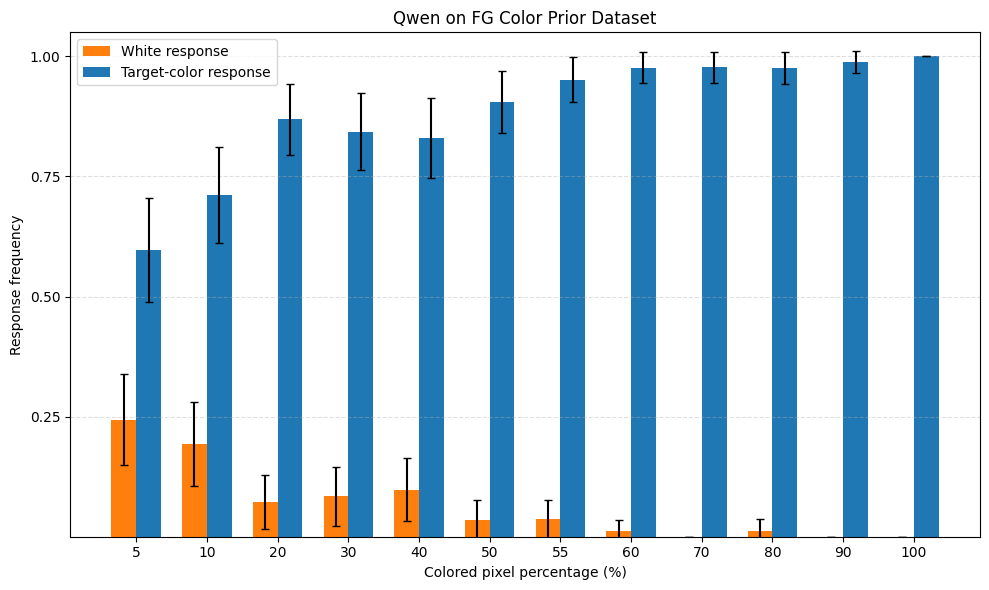

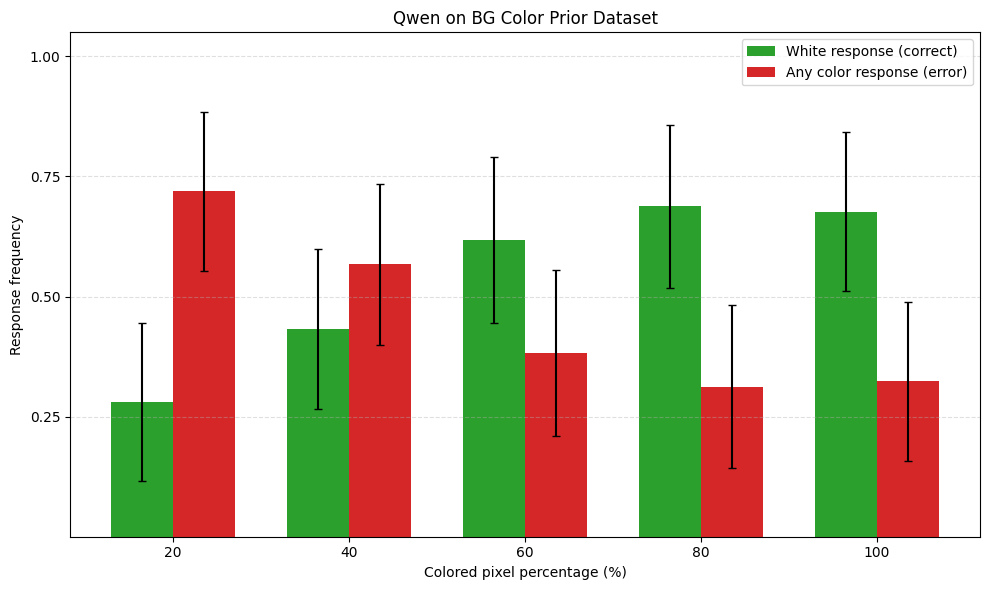

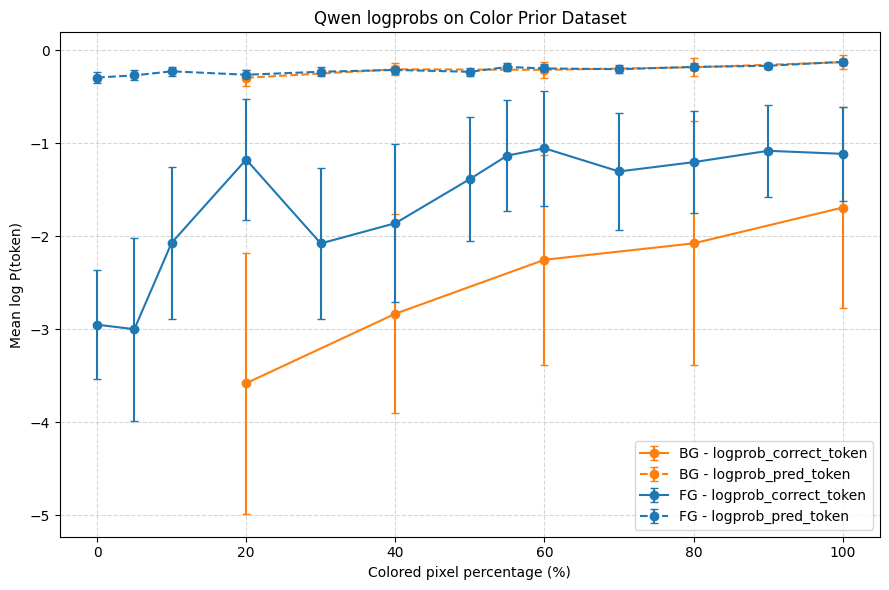

In [30]:
qwen_prior_pred_df = pd.read_csv(QWEN / f"evaluation_{qwen_model_name}_image_priors.csv")
qwen_prior_pred_df["response_label"] = qwen_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
qwen_prior_pred_df["intro_position"] = "last"
qwen_prior_pred_df = qwen_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(qwen_prior_pred_df)

plot_fg_response_frequencies_bar(qwen_prior_pred_df, title="Qwen on FG Color Prior Dataset", response_col="response_label")
plot_bg_response_frequencies_bar(qwen_prior_pred_df, title="Qwen on BG Color Prior Dataset", response_col="response_label")

plot_model_logprobs(
    qwen_prior_pred_df,
    title="Qwen logprobs on Color Prior Dataset"
)

## 3.2.2. Color Prior Dataset with Introspection Question (Qwen3-VL)

In [40]:
suffix = "image_priors"
introsp_qwen_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA,
    calibration_value=qwen_threshold,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = QWEN / f"introsp_evaluation_{qwen_model_name}_{suffix}.csv"
introsp_qwen_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [12:57<00:00,  1.62it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,yellow,-0.226642,-1.601642,True,50,50,yellow,first,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-0.042914,-0.042914,True,50,50,red,first,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.011053,-0.011053,True,50,50,red,first,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.046637,-6.577887,True,50,50,grey,first,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.003491,-0.003491,True,50,50,brown,first,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.155674,-0.155674,True,50,50,purple,first,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.101357,-2.413857,True,50,50,black,first,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.072086,-0.072086,True,50,50,brown,first,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.045712,-0.045712,True,50,50,green,first,correct_prior,green,green,FG,50,FG 50% (seq),seq


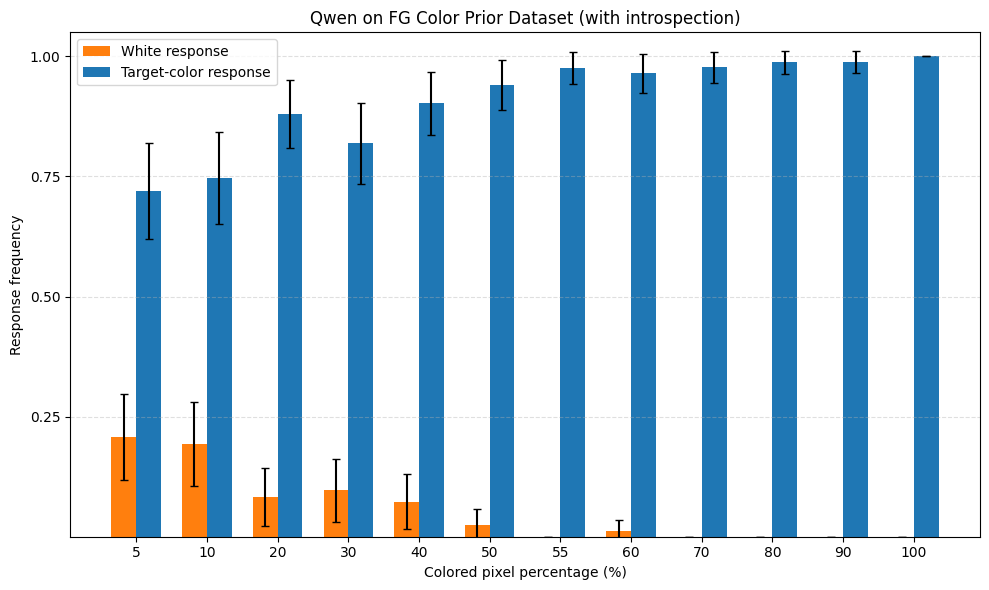

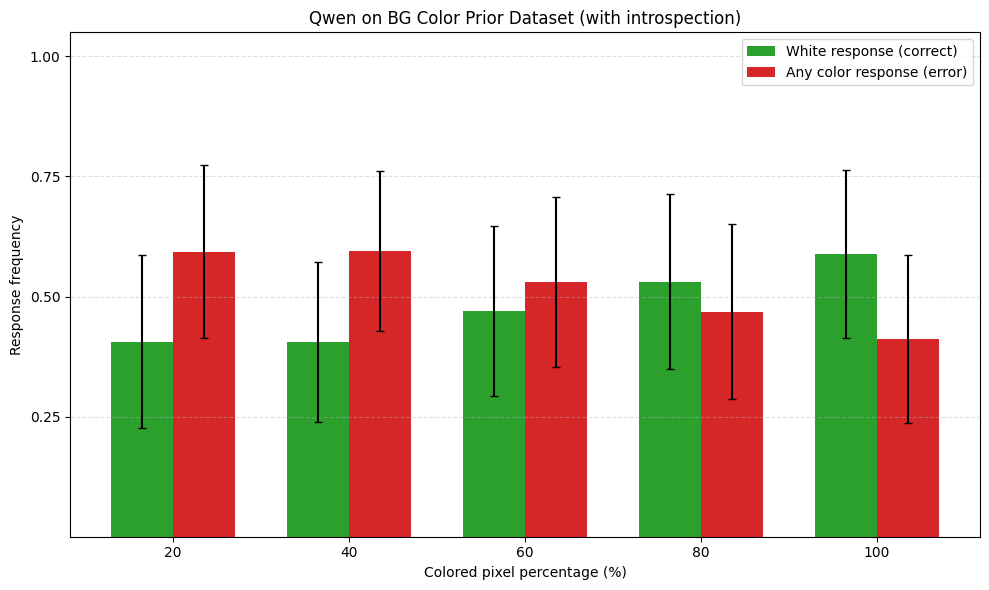

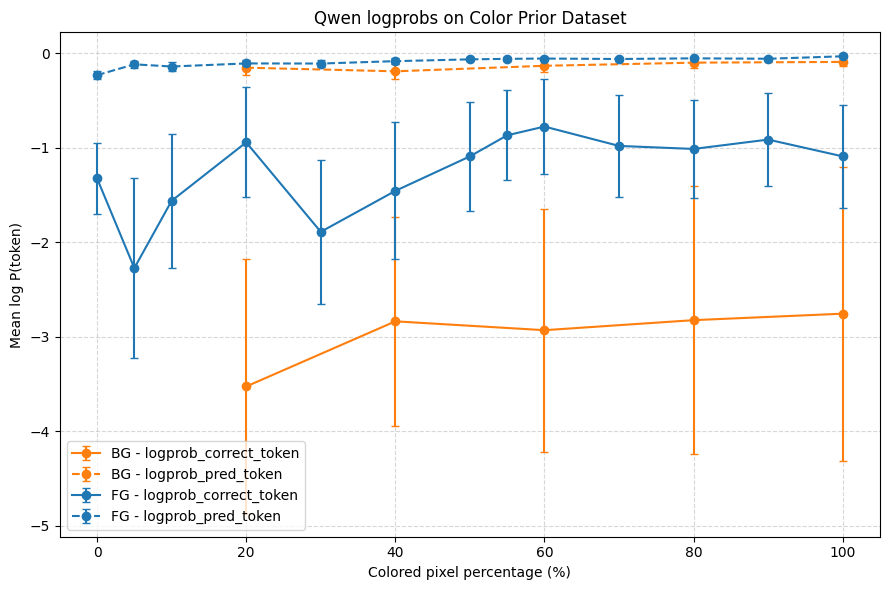

In [31]:
introsp_qwen_prior_pred_df = pd.read_csv(QWEN / f"introsp_evaluation_{qwen_model_name}_image_priors.csv")
introsp_qwen_prior_pred_df["response_label"] = introsp_qwen_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_qwen_prior_pred_df["intro_position"] = "first"
introsp_qwen_prior_pred_df = introsp_qwen_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_qwen_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_qwen_prior_pred_df, title="Qwen on FG Color Prior Dataset (with introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_qwen_prior_pred_df, title="Qwen on BG Color Prior Dataset (with introspection)", response_col="response_label")
plot_model_logprobs(
    introsp_qwen_prior_pred_df,
    title="Qwen logprobs on Color Prior Dataset"
)

## 3.3.1. Counterfact Color Dataset (Qwen3-VL)

In [41]:
suffix = "counterfact"
qwen_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA
)

out_path = QWEN / f"evaluation_{qwen_model_name}_{suffix}.csv"
qwen_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [04:13<00:00,  1.62it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.043000,-0.043000,True,NaN,blue,last,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.016559,-0.016559,True,NaN,purple,last,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.086337,-0.086337,True,NaN,orange,last,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.411360,-0.411360,True,NaN,red,last,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.202929,-2.077929,True,NaN,white,last,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.142738,-0.142738,True,NaN,orange,last,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,pink,-0.209336,-0.209336,True,NaN,pink,last,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.116236,-0.116236,True,NaN,purple,last,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.562383,-0.562383,True,NaN,green,last,counterfact,green,green,FG,70,FG 70% (seq),seq


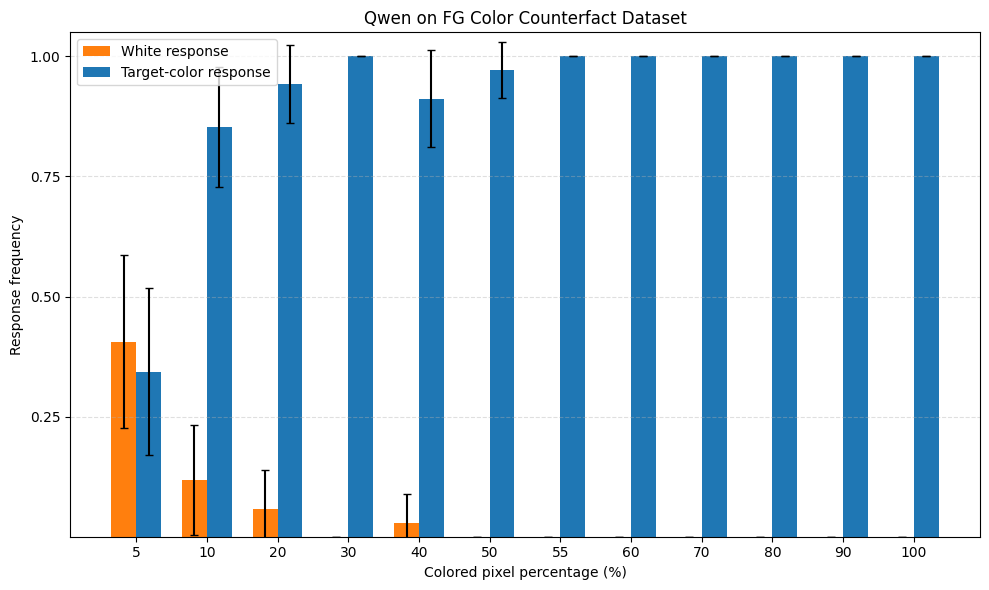

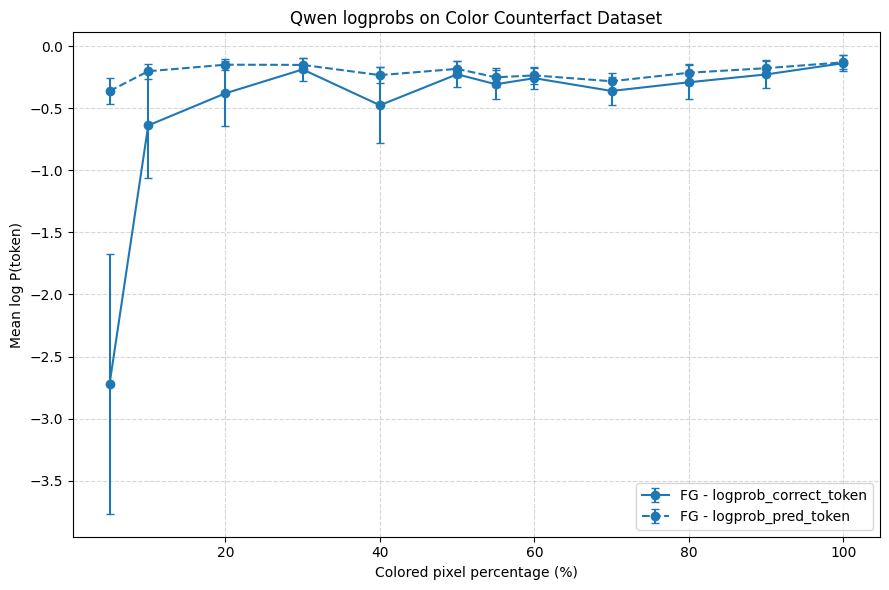

In [32]:
qwen_cf_pred_df = pd.read_csv(QWEN / f"evaluation_{qwen_model_name}_counterfact.csv")
qwen_cf_pred_df["response_label"] = qwen_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
qwen_cf_pred_df["intro_position"] = "last"
qwen_cf_pred_df = qwen_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(qwen_cf_pred_df)


plot_fg_response_frequencies_bar(qwen_cf_pred_df, title="Qwen on FG Color Counterfact Dataset", response_col="response_label")

plot_model_logprobs(
    qwen_cf_pred_df,
    title="Qwen logprobs on Color Counterfact Dataset"
)

## 3.3.2. Counterfact Color Dataset with Introspection Question (Qwen3-VL)

In [42]:
suffix = "counterfact"
introsp_qwen_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    calibration_value=qwen_threshold,
    image_root=DATA
)

out_path = QWEN / f"introsp_evaluation_{qwen_model_name}_{suffix}.csv"
introsp_qwen_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [04:11<00:00,  1.64it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.078897,-0.078897,True,50,50,blue,first,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.005944,-0.005944,True,50,50,purple,first,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.010746,-0.010746,True,50,50,orange,first,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.245520,-0.245520,True,50,50,red,first,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.141598,-2.141598,True,50,50,white,first,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.010737,-0.010737,True,50,50,orange,first,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,pink,-0.600624,-0.600624,True,50,50,pink,first,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.011065,-0.011065,True,50,50,purple,first,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.025502,-0.025502,True,50,50,green,first,counterfact,green,green,FG,70,FG 70% (seq),seq


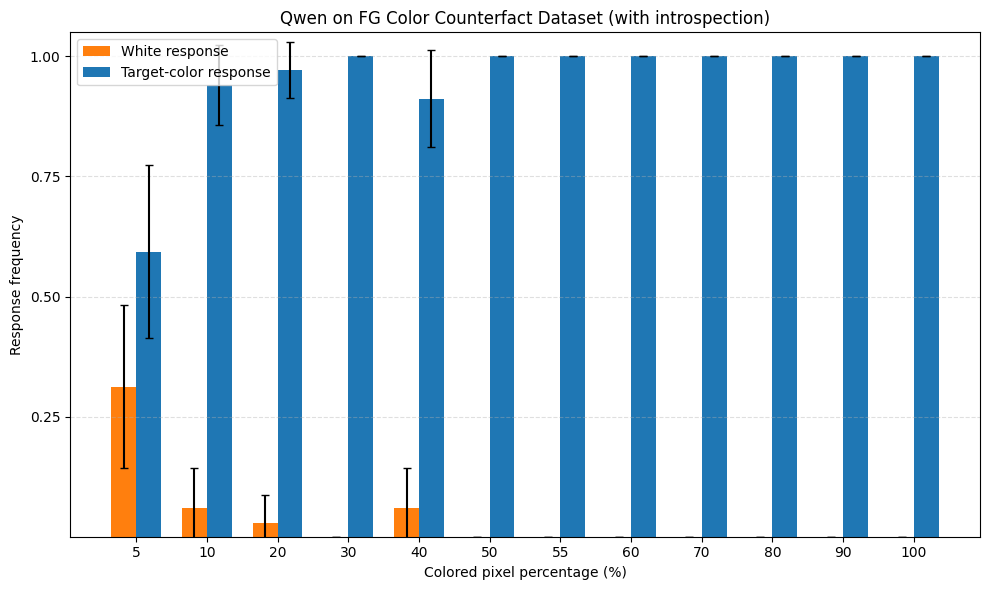

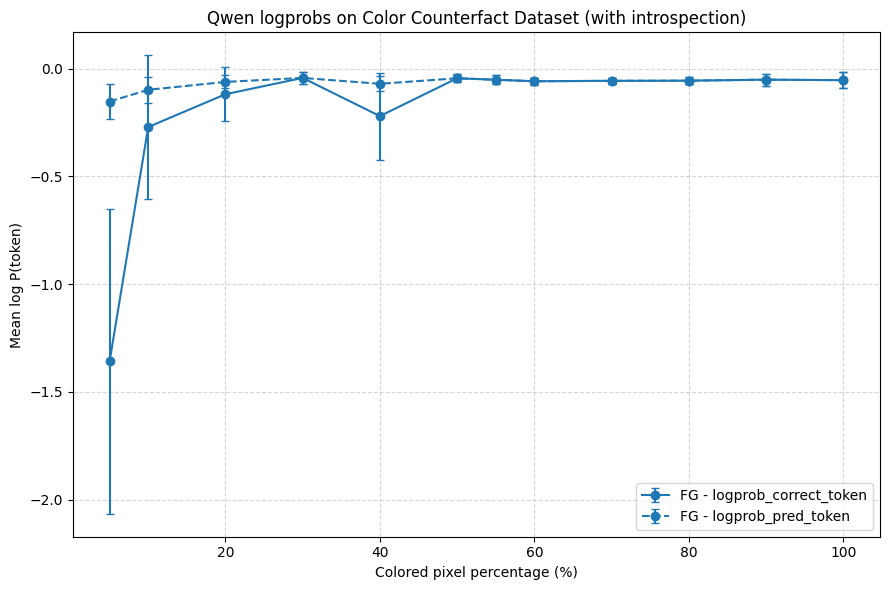

In [33]:
introsp_qwen_cf_pred_df = pd.read_csv(QWEN / f"introsp_evaluation_{qwen_model_name}_counterfact.csv")
introsp_qwen_cf_pred_df["response_label"] = introsp_qwen_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_qwen_cf_pred_df["intro_position"] = "first"
introsp_qwen_cf_pred_df = introsp_qwen_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_qwen_cf_pred_df)


plot_fg_response_frequencies_bar(introsp_qwen_cf_pred_df, title="Qwen on FG Color Counterfact Dataset (with introspection)", response_col="response_label")
plot_model_logprobs(
    introsp_qwen_cf_pred_df,
    title="Qwen logprobs on Color Counterfact Dataset (with introspection)"
)

## 3.4.1. Shape Dataset (Qwen3-VL)

In [43]:
suffix = "shapes"
qwen_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA
)

out_path = QWEN / f"evaluation_{qwen_model_name}_{suffix}.csv"
qwen_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [13:37<00:00,  1.63it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.001331,-0.001331,True,NaN,yellow,last,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.056603,-0.056603,True,NaN,purple,last,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,blue,-0.061692,-0.061692,True,NaN,blue,last,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.002071,-0.002071,True,NaN,brown,last,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.015554,-0.015554,True,NaN,orange,last,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,black,-0.548355,-8.860855,False,NaN,black,last,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.018741,-0.018741,True,NaN,brown,last,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.677862,-0.677862,True,NaN,white,last,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.015067,-0.015067,True,NaN,white,last,shape,red,white,BG,40,BG 40% (seq),seq


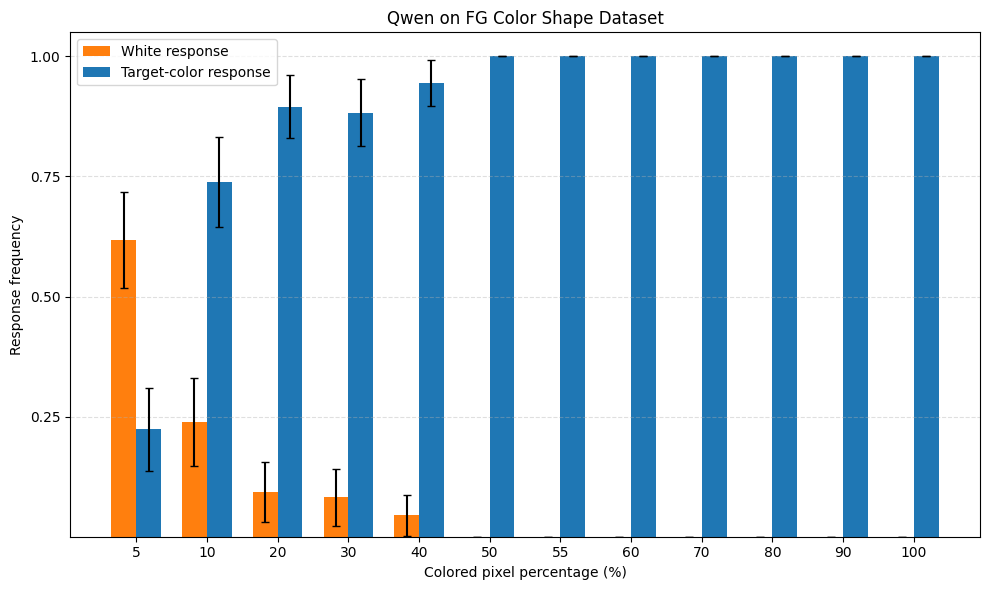

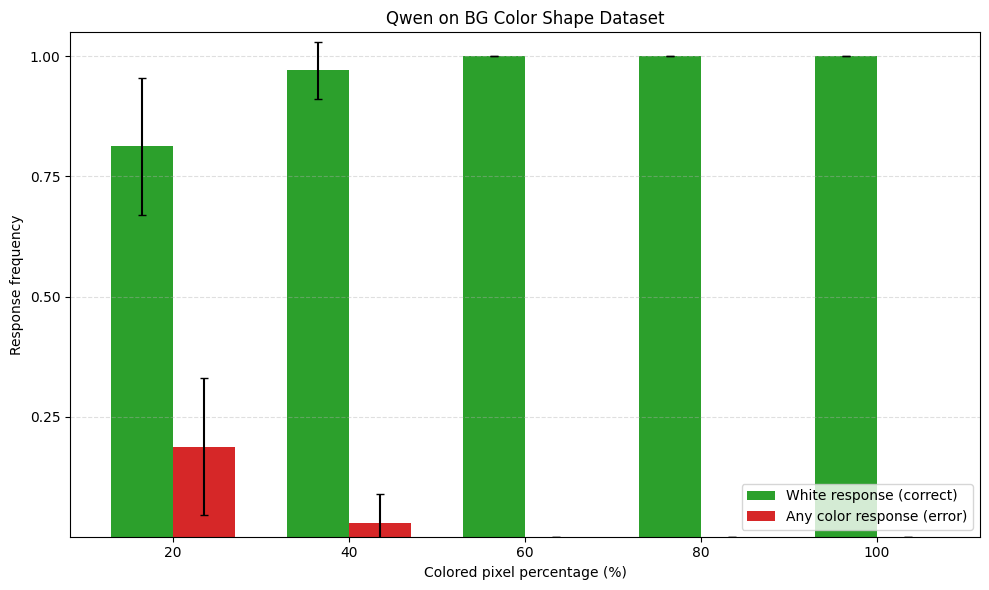

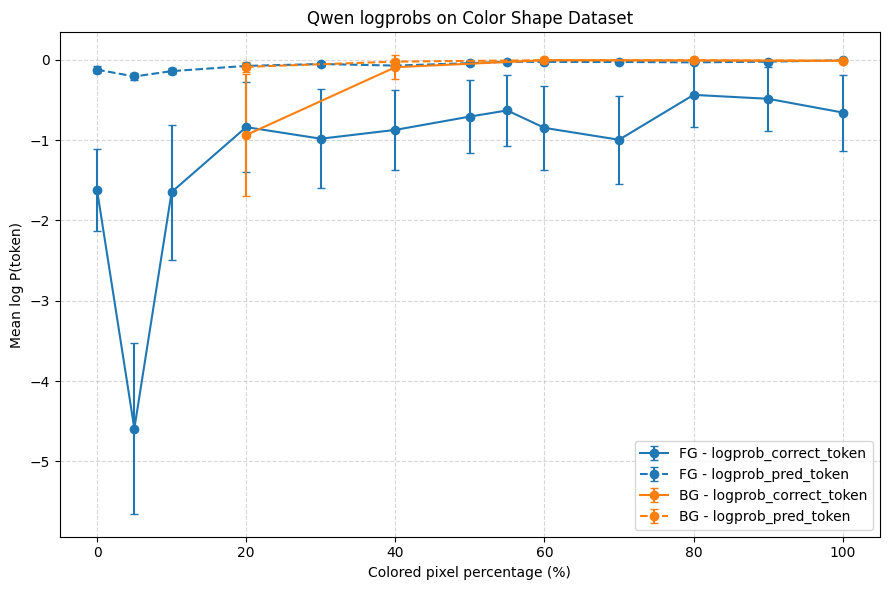

In [34]:
qwen_shape_pred_df = pd.read_csv(QWEN / f"evaluation_{qwen_model_name}_shapes.csv")
qwen_shape_pred_df["response_label"] = qwen_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
qwen_shape_pred_df["intro_position"] = "last"
qwen_shape_pred_df = qwen_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(qwen_shape_pred_df)

plot_fg_response_frequencies_bar(qwen_shape_pred_df, title="Qwen on FG Color Shape Dataset", response_col="response_label")
plot_bg_response_frequencies_bar(qwen_shape_pred_df, title="Qwen on BG Color Shape Dataset", response_col="response_label")

plot_model_logprobs(
    qwen_shape_pred_df,
    title="Qwen logprobs on Color Shape Dataset"
)

## 3.4.2. Shape Dataset with Introspection Question (Qwen3-VL)

In [44]:
suffix = "shapes"
introsp_qwen_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    calibration_value=qwen_threshold,
    image_root=DATA
)

out_path = QWEN / f"introsp_evaluation_{qwen_model_name}_{suffix}.csv"
introsp_qwen_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [13:51<00:00,  1.60it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.001458,-0.001458,True,50,50,yellow,first,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.081318,-0.081318,True,50,50,purple,first,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,blue,-0.038924,-0.038924,True,50,50,blue,first,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.023266,-0.023266,True,50,50,brown,first,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.081312,-0.081312,True,50,50,orange,first,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.065168,-7.127668,True,50,50,grey,first,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.047143,-0.047143,True,50,50,brown,first,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.377229,-0.377229,True,50,50,white,first,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.043655,-0.043655,True,50,50,white,first,shape,red,white,BG,40,BG 40% (seq),seq


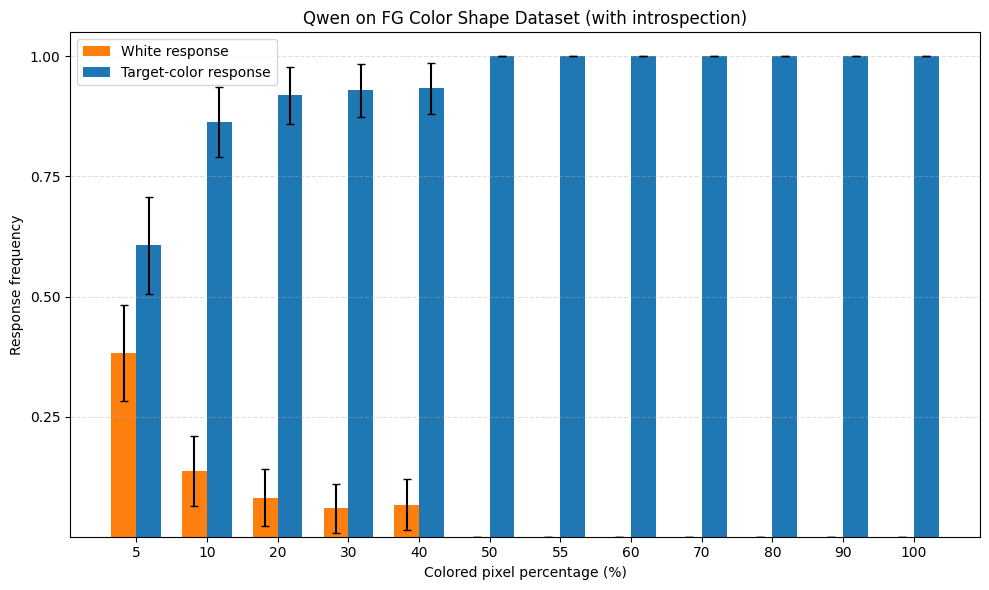

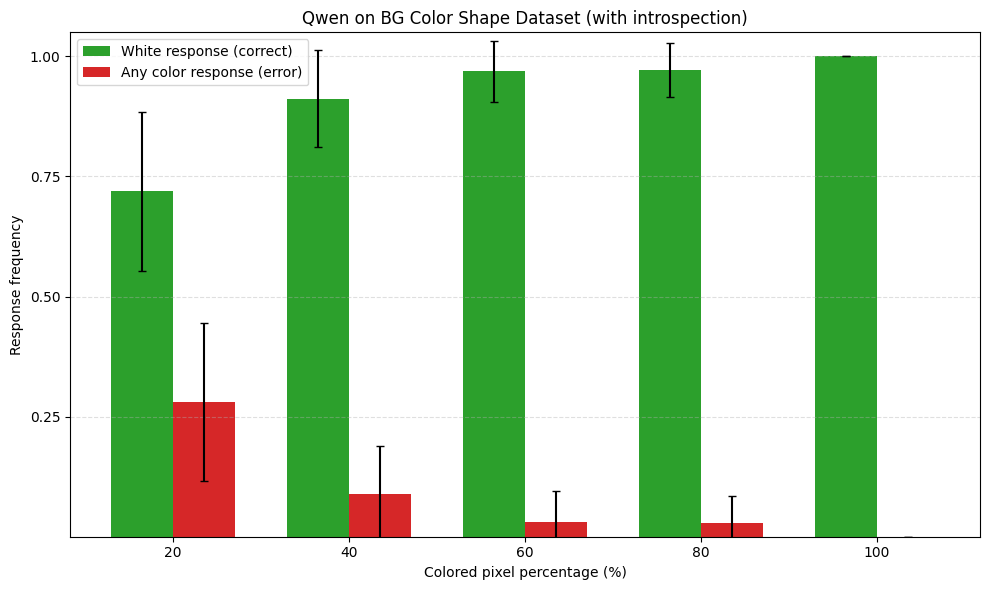

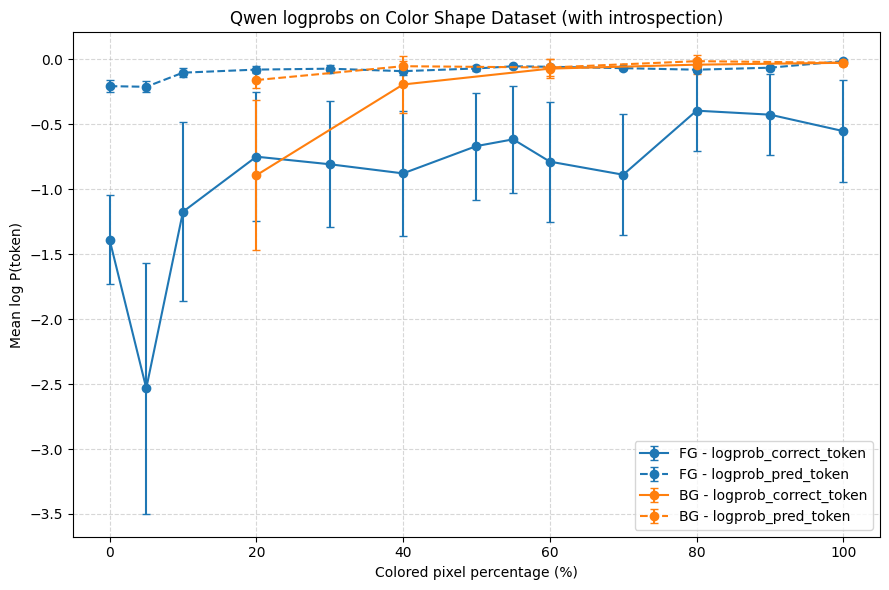

In [35]:
introsp_qwen_shape_pred_df = pd.read_csv(QWEN / f"introsp_evaluation_{qwen_model_name}_shapes.csv")
introsp_qwen_shape_pred_df["response_label"] = introsp_qwen_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_qwen_shape_pred_df["intro_position"] = "first"
introsp_qwen_shape_pred_df = introsp_qwen_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_qwen_shape_pred_df)

plot_fg_response_frequencies_bar(introsp_qwen_shape_pred_df, title="Qwen on FG Color Shape Dataset (with introspection)", response_col="response_label")
plot_bg_response_frequencies_bar(introsp_qwen_shape_pred_df, title="Qwen on BG Color Shape Dataset (with introspection)", response_col="response_label")

plot_model_logprobs(
    introsp_qwen_shape_pred_df,
    title="Qwen logprobs on Color Shape Dataset (with introspection)"
)

In [37]:
# Combine all Qwen results into one dataframe for easier comparison and plotting
qwen_combined_df = pd.concat(
    [
        qwen_prior_pred_df,
        introsp_qwen_prior_pred_df,
        qwen_cf_pred_df,
        introsp_qwen_cf_pred_df,
        qwen_shape_pred_df,
        introsp_qwen_shape_pred_df,
    ],
    ignore_index=True
)
qwen_combined_df = qwen_combined_df.drop(columns=["calibration_threshold", "prob_correct_this"], errors="ignore")
display(qwen_combined_df)
qwen_combined_df.to_csv(QWEN / f"evaluation_{qwen_model_name}_combined.csv", index=False)

,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,response_label,intro_position,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.111229,-0.111229,True,NaN,white,last,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-0.680644,-0.711894,True,NaN,red,last,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.020549,-0.020549,True,NaN,red,last,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.045944,-6.764694,True,NaN,grey,last,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.040452,-0.040452,True,NaN,brown,last,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.065168,-7.127668,True,50.0,grey,first,shape,grey,grey,FG,40,FG 40% (seq),seq
6002,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.047143,-0.047143,True,50.0,brown,first,shape,brown,brown,FG,70,FG 70% (seq),seq
6003,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.377229,-0.377229,True,50.0,white,first,shape,blue,white,FG,0,FG 0% (seq),seq
6004,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.043655,-0.043655,True,50.0,white,first,shape,red,white,BG,40,BG 40% (seq),seq
